In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 648)
(3944610, 8)
validation
(464344, 648)
(464344, 8)
test
(574820, 648)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 8:59 - loss: 2.3728 - STD: 0.0948 - MAE: 0.2197

  5/395 [..............................] - ETA: 5s - loss: 2.1491 - STD: 0.0576 - MAE: 0.2172  

  9/395 [..............................] - ETA: 5s - loss: 2.1259 - STD: 0.0572 - MAE: 0.2166

 13/395 [..............................] - ETA: 5s - loss: 2.1065 - STD: 0.0509 - MAE: 0.2166

 17/395 [>.............................] - ETA: 5s - loss: 2.0948 - STD: 0.0463 - MAE: 0.2167

 21/395 [>.............................] - ETA: 5s - loss: 2.0881 - STD: 0.0436 - MAE: 0.2167

 25/395 [>.............................] - ETA: 5s - loss: 2.0822 - STD: 0.0419 - MAE: 0.2167

 29/395 [=>............................] - ETA: 5s - loss: 2.0772 - STD: 0.0409 - MAE: 0.2167

 33/395 [=>............................] - ETA: 5s - loss: 2.0732 - STD: 0.0401 - MAE: 0.2166

 37/395 [=>............................] - ETA: 4s - loss: 2.0689 - STD: 0.0394 - MAE: 0.2166

 41/395 [==>...........................] - ETA: 4s - loss: 2.0640 - STD: 0.0388 - MAE: 0.2164

 45/395 [==>...........................] - ETA: 4s - loss: 2.0578 - STD: 0.0386 - MAE: 0.2163

 49/395 [==>...........................] - ETA: 4s - loss: 2.0500 - STD: 0.0389 - MAE: 0.2160

 53/395 [===>..........................] - ETA: 4s - loss: 2.0408 - STD: 0.0402 - MAE: 0.2156

 54/395 [===>..........................] - ETA: 9s - loss: 2.0398 - STD: 0.0406 - MAE: 0.2155

 58/395 [===>..........................] - ETA: 8s - loss: 2.0292 - STD: 0.0423 - MAE: 0.2149

 62/395 [===>..........................] - ETA: 8s - loss: 2.0176 - STD: 0.0441 - MAE: 0.2144

 66/395 [====>.........................] - ETA: 7s - loss: 2.0052 - STD: 0.0461 - MAE: 0.2138

 70/395 [====>.........................] - ETA: 7s - loss: 1.9920 - STD: 0.0482 - MAE: 0.2131

 74/395 [====>.........................] - ETA: 7s - loss: 1.9786 - STD: 0.0503 - MAE: 0.2124

 78/395 [====>.........................] - ETA: 7s - loss: 1.9649 - STD: 0.0524 - MAE: 0.2117

 82/395 [=====>........................] - ETA: 6s - loss: 1.9505 - STD: 0.0545 - MAE: 0.2110

 86/395 [=====>........................] - ETA: 6s - loss: 1.9356 - STD: 0.0567 - MAE: 0.2102

 90/395 [=====>........................] - ETA: 6s - loss: 1.9199 - STD: 0.0590 - MAE: 0.2093

 94/395 [======>.......................] - ETA: 6s - loss: 1.9042 - STD: 0.0615 - MAE: 0.2084

 98/395 [======>.......................] - ETA: 6s - loss: 1.8887 - STD: 0.0640 - MAE: 0.2074

102/395 [======>.......................] - ETA: 6s - loss: 1.8737 - STD: 0.0665 - MAE: 0.2065

106/395 [=======>......................] - ETA: 5s - loss: 1.8591 - STD: 0.0688 - MAE: 0.2056

110/395 [=======>......................] - ETA: 5s - loss: 1.8452 - STD: 0.0711 - MAE: 0.2047

114/395 [=======>......................] - ETA: 5s - loss: 1.8319 - STD: 0.0733 - MAE: 0.2038

118/395 [=======>......................] - ETA: 5s - loss: 1.8192 - STD: 0.0754 - MAE: 0.2030

122/395 [========>.....................] - ETA: 5s - loss: 1.8071 - STD: 0.0774 - MAE: 0.2022

126/395 [========>.....................] - ETA: 5s - loss: 1.7951 - STD: 0.0793 - MAE: 0.2014

130/395 [========>.....................] - ETA: 5s - loss: 1.7838 - STD: 0.0812 - MAE: 0.2007

134/395 [=========>....................] - ETA: 4s - loss: 1.7729 - STD: 0.0830 - MAE: 0.1999

138/395 [=========>....................] - ETA: 4s - loss: 1.7627 - STD: 0.0847 - MAE: 0.1992

142/395 [=========>....................] - ETA: 4s - loss: 1.7526 - STD: 0.0863 - MAE: 0.1985

146/395 [==========>...................] - ETA: 4s - loss: 1.7428 - STD: 0.0879 - MAE: 0.1978

150/395 [==========>...................] - ETA: 4s - loss: 1.7333 - STD: 0.0894 - MAE: 0.1972

154/395 [==========>...................] - ETA: 4s - loss: 1.7243 - STD: 0.0909 - MAE: 0.1966

158/395 [===========>..................] - ETA: 4s - loss: 1.7152 - STD: 0.0924 - MAE: 0.1959

162/395 [===========>..................] - ETA: 4s - loss: 1.7065 - STD: 0.0938 - MAE: 0.1953

166/395 [===========>..................] - ETA: 4s - loss: 1.6984 - STD: 0.0951 - MAE: 0.1947

170/395 [===========>..................] - ETA: 4s - loss: 1.6902 - STD: 0.0965 - MAE: 0.1941

174/395 [============>.................] - ETA: 3s - loss: 1.6824 - STD: 0.0978 - MAE: 0.1935

178/395 [============>.................] - ETA: 3s - loss: 1.6750 - STD: 0.0990 - MAE: 0.1929

182/395 [============>.................] - ETA: 3s - loss: 1.6676 - STD: 0.1003 - MAE: 0.1924

186/395 [=============>................] - ETA: 3s - loss: 1.6604 - STD: 0.1015 - MAE: 0.1918

190/395 [=============>................] - ETA: 3s - loss: 1.6534 - STD: 0.1027 - MAE: 0.1913

194/395 [=============>................] - ETA: 3s - loss: 1.6468 - STD: 0.1038 - MAE: 0.1908

198/395 [==============>...............] - ETA: 3s - loss: 1.6400 - STD: 0.1050 - MAE: 0.1902

202/395 [==============>...............] - ETA: 3s - loss: 1.6336 - STD: 0.1061 - MAE: 0.1897

206/395 [==============>...............] - ETA: 3s - loss: 1.6272 - STD: 0.1071 - MAE: 0.1892

210/395 [==============>...............] - ETA: 3s - loss: 1.6212 - STD: 0.1082 - MAE: 0.1888

214/395 [===============>..............] - ETA: 3s - loss: 1.6152 - STD: 0.1092 - MAE: 0.1883

218/395 [===============>..............] - ETA: 2s - loss: 1.6091 - STD: 0.1102 - MAE: 0.1878

222/395 [===============>..............] - ETA: 2s - loss: 1.6033 - STD: 0.1112 - MAE: 0.1873

226/395 [================>.............] - ETA: 2s - loss: 1.5976 - STD: 0.1122 - MAE: 0.1869

230/395 [================>.............] - ETA: 2s - loss: 1.5922 - STD: 0.1131 - MAE: 0.1864

234/395 [================>.............] - ETA: 2s - loss: 1.5867 - STD: 0.1140 - MAE: 0.1860

238/395 [=================>............] - ETA: 2s - loss: 1.5814 - STD: 0.1149 - MAE: 0.1856

242/395 [=================>............] - ETA: 2s - loss: 1.5766 - STD: 0.1158 - MAE: 0.1851

246/395 [=================>............] - ETA: 2s - loss: 1.5718 - STD: 0.1167 - MAE: 0.1847

250/395 [=================>............] - ETA: 2s - loss: 1.5670 - STD: 0.1175 - MAE: 0.1843

254/395 [==================>...........] - ETA: 2s - loss: 1.5623 - STD: 0.1184 - MAE: 0.1839

258/395 [==================>...........] - ETA: 2s - loss: 1.5576 - STD: 0.1192 - MAE: 0.1836

262/395 [==================>...........] - ETA: 2s - loss: 1.5530 - STD: 0.1199 - MAE: 0.1832

266/395 [===================>..........] - ETA: 2s - loss: 1.5485 - STD: 0.1207 - MAE: 0.1828

270/395 [===================>..........] - ETA: 2s - loss: 1.5440 - STD: 0.1215 - MAE: 0.1824

274/395 [===================>..........] - ETA: 1s - loss: 1.5397 - STD: 0.1222 - MAE: 0.1821

278/395 [====================>.........] - ETA: 1s - loss: 1.5354 - STD: 0.1229 - MAE: 0.1817

282/395 [====================>.........] - ETA: 1s - loss: 1.5312 - STD: 0.1237 - MAE: 0.1814

286/395 [====================>.........] - ETA: 1s - loss: 1.5271 - STD: 0.1244 - MAE: 0.1810

290/395 [=====================>........] - ETA: 1s - loss: 1.5231 - STD: 0.1251 - MAE: 0.1807

294/395 [=====================>........] - ETA: 1s - loss: 1.5191 - STD: 0.1257 - MAE: 0.1803

298/395 [=====================>........] - ETA: 1s - loss: 1.5153 - STD: 0.1264 - MAE: 0.1800

302/395 [=====================>........] - ETA: 1s - loss: 1.5116 - STD: 0.1271 - MAE: 0.1797

306/395 [======================>.......] - ETA: 1s - loss: 1.5078 - STD: 0.1277 - MAE: 0.1793

310/395 [======================>.......] - ETA: 1s - loss: 1.5041 - STD: 0.1283 - MAE: 0.1790

314/395 [======================>.......] - ETA: 1s - loss: 1.5004 - STD: 0.1290 - MAE: 0.1787

318/395 [=======================>......] - ETA: 1s - loss: 1.4969 - STD: 0.1296 - MAE: 0.1784

322/395 [=======================>......] - ETA: 1s - loss: 1.4937 - STD: 0.1302 - MAE: 0.1781

326/395 [=======================>......] - ETA: 1s - loss: 1.4903 - STD: 0.1308 - MAE: 0.1778

330/395 [========================>.....] - ETA: 1s - loss: 1.4870 - STD: 0.1314 - MAE: 0.1775

334/395 [========================>.....] - ETA: 0s - loss: 1.4838 - STD: 0.1319 - MAE: 0.1772

338/395 [========================>.....] - ETA: 0s - loss: 1.4807 - STD: 0.1325 - MAE: 0.1770

342/395 [========================>.....] - ETA: 0s - loss: 1.4775 - STD: 0.1330 - MAE: 0.1767

346/395 [=========================>....] - ETA: 0s - loss: 1.4745 - STD: 0.1336 - MAE: 0.1764

350/395 [=========================>....] - ETA: 0s - loss: 1.4714 - STD: 0.1341 - MAE: 0.1761

354/395 [=========================>....] - ETA: 0s - loss: 1.4683 - STD: 0.1346 - MAE: 0.1759

358/395 [==========================>...] - ETA: 0s - loss: 1.4654 - STD: 0.1351 - MAE: 0.1756

362/395 [==========================>...] - ETA: 0s - loss: 1.4625 - STD: 0.1356 - MAE: 0.1754

366/395 [==========================>...] - ETA: 0s - loss: 1.4596 - STD: 0.1361 - MAE: 0.1751

370/395 [===========================>..] - ETA: 0s - loss: 1.4566 - STD: 0.1366 - MAE: 0.1748

374/395 [===========================>..] - ETA: 0s - loss: 1.4538 - STD: 0.1371 - MAE: 0.1746

378/395 [===========================>..] - ETA: 0s - loss: 1.4510 - STD: 0.1376 - MAE: 0.1743

382/395 [============================>.] - ETA: 0s - loss: 1.4482 - STD: 0.1380 - MAE: 0.1741

386/395 [============================>.] - ETA: 0s - loss: 1.4455 - STD: 0.1385 - MAE: 0.1739

390/395 [============================>.] - ETA: 0s - loss: 1.4431 - STD: 0.1390 - MAE: 0.1736

394/395 [============================>.] - ETA: 0s - loss: 1.4408 - STD: 0.1394 - MAE: 0.1734

395/395 [==============================] - 9s 18ms/step - loss: 1.4403 - STD: 0.1395 - MAE: 0.1734 - val_loss: 1.2740 - val_STD: 0.1850 - val_MAE: 0.1523


Epoch 2/10000


  1/395 [..............................] - ETA: 16s - loss: 1.2301 - STD: 0.1825 - MAE: 0.1529

  5/395 [..............................] - ETA: 5s - loss: 1.2065 - STD: 0.1827 - MAE: 0.1517 

  9/395 [..............................] - ETA: 5s - loss: 1.1975 - STD: 0.1830 - MAE: 0.1512

 13/395 [..............................] - ETA: 5s - loss: 1.1930 - STD: 0.1830 - MAE: 0.1509

 17/395 [>.............................] - ETA: 5s - loss: 1.1880 - STD: 0.1830 - MAE: 0.1506

 21/395 [>.............................] - ETA: 5s - loss: 1.1859 - STD: 0.1831 - MAE: 0.1506

 25/395 [>.............................] - ETA: 5s - loss: 1.1852 - STD: 0.1833 - MAE: 0.1504

 29/395 [=>............................] - ETA: 5s - loss: 1.1840 - STD: 0.1834 - MAE: 0.1503

 33/395 [=>............................] - ETA: 5s - loss: 1.1817 - STD: 0.1835 - MAE: 0.1501

 37/395 [=>............................] - ETA: 5s - loss: 1.1804 - STD: 0.1837 - MAE: 0.1500

 41/395 [==>...........................] - ETA: 5s - loss: 1.1787 - STD: 0.1839 - MAE: 0.1499

 45/395 [==>...........................] - ETA: 4s - loss: 1.1778 - STD: 0.1840 - MAE: 0.1498

 49/395 [==>...........................] - ETA: 4s - loss: 1.1766 - STD: 0.1842 - MAE: 0.1496

 53/395 [===>..........................] - ETA: 4s - loss: 1.1754 - STD: 0.1844 - MAE: 0.1495

 57/395 [===>..........................] - ETA: 4s - loss: 1.1741 - STD: 0.1846 - MAE: 0.1494

 61/395 [===>..........................] - ETA: 4s - loss: 1.1727 - STD: 0.1847 - MAE: 0.1493

 65/395 [===>..........................] - ETA: 4s - loss: 1.1714 - STD: 0.1849 - MAE: 0.1491

 69/395 [====>.........................] - ETA: 4s - loss: 1.1705 - STD: 0.1851 - MAE: 0.1490

 73/395 [====>.........................] - ETA: 4s - loss: 1.1698 - STD: 0.1852 - MAE: 0.1489

 77/395 [====>.........................] - ETA: 4s - loss: 1.1696 - STD: 0.1853 - MAE: 0.1489

 81/395 [=====>........................] - ETA: 4s - loss: 1.1694 - STD: 0.1854 - MAE: 0.1488

 85/395 [=====>........................] - ETA: 4s - loss: 1.1687 - STD: 0.1855 - MAE: 0.1487

 89/395 [=====>........................] - ETA: 4s - loss: 1.1678 - STD: 0.1856 - MAE: 0.1486

 93/395 [======>.......................] - ETA: 4s - loss: 1.1673 - STD: 0.1857 - MAE: 0.1486

 97/395 [======>.......................] - ETA: 4s - loss: 1.1668 - STD: 0.1858 - MAE: 0.1485

101/395 [======>.......................] - ETA: 4s - loss: 1.1666 - STD: 0.1859 - MAE: 0.1485

105/395 [======>.......................] - ETA: 4s - loss: 1.1663 - STD: 0.1860 - MAE: 0.1484

109/395 [=======>......................] - ETA: 3s - loss: 1.1658 - STD: 0.1861 - MAE: 0.1484

113/395 [=======>......................] - ETA: 3s - loss: 1.1655 - STD: 0.1862 - MAE: 0.1483

117/395 [=======>......................] - ETA: 3s - loss: 1.1650 - STD: 0.1863 - MAE: 0.1483

121/395 [========>.....................] - ETA: 3s - loss: 1.1643 - STD: 0.1863 - MAE: 0.1482

125/395 [========>.....................] - ETA: 3s - loss: 1.1634 - STD: 0.1864 - MAE: 0.1482

129/395 [========>.....................] - ETA: 3s - loss: 1.1625 - STD: 0.1865 - MAE: 0.1481

133/395 [=========>....................] - ETA: 3s - loss: 1.1615 - STD: 0.1866 - MAE: 0.1480

137/395 [=========>....................] - ETA: 3s - loss: 1.1605 - STD: 0.1867 - MAE: 0.1479

141/395 [=========>....................] - ETA: 3s - loss: 1.1598 - STD: 0.1868 - MAE: 0.1478

145/395 [==========>...................] - ETA: 3s - loss: 1.1593 - STD: 0.1869 - MAE: 0.1477

149/395 [==========>...................] - ETA: 3s - loss: 1.1586 - STD: 0.1870 - MAE: 0.1477

153/395 [==========>...................] - ETA: 3s - loss: 1.1579 - STD: 0.1871 - MAE: 0.1476

157/395 [==========>...................] - ETA: 3s - loss: 1.1570 - STD: 0.1872 - MAE: 0.1475

161/395 [===========>..................] - ETA: 3s - loss: 1.1563 - STD: 0.1873 - MAE: 0.1475

165/395 [===========>..................] - ETA: 3s - loss: 1.1553 - STD: 0.1874 - MAE: 0.1474

169/395 [===========>..................] - ETA: 3s - loss: 1.1548 - STD: 0.1875 - MAE: 0.1473

173/395 [============>.................] - ETA: 3s - loss: 1.1543 - STD: 0.1876 - MAE: 0.1472

177/395 [============>.................] - ETA: 3s - loss: 1.1538 - STD: 0.1877 - MAE: 0.1472

181/395 [============>.................] - ETA: 2s - loss: 1.1532 - STD: 0.1878 - MAE: 0.1471

185/395 [=============>................] - ETA: 2s - loss: 1.1526 - STD: 0.1879 - MAE: 0.1471

189/395 [=============>................] - ETA: 2s - loss: 1.1520 - STD: 0.1880 - MAE: 0.1470

193/395 [=============>................] - ETA: 2s - loss: 1.1512 - STD: 0.1880 - MAE: 0.1469

197/395 [=============>................] - ETA: 2s - loss: 1.1506 - STD: 0.1881 - MAE: 0.1469

201/395 [==============>...............] - ETA: 2s - loss: 1.1498 - STD: 0.1882 - MAE: 0.1468

205/395 [==============>...............] - ETA: 2s - loss: 1.1490 - STD: 0.1883 - MAE: 0.1467

209/395 [==============>...............] - ETA: 2s - loss: 1.1484 - STD: 0.1884 - MAE: 0.1467

214/395 [===============>..............] - ETA: 2s - loss: 1.1476 - STD: 0.1885 - MAE: 0.1466

218/395 [===============>..............] - ETA: 2s - loss: 1.1469 - STD: 0.1886 - MAE: 0.1465

222/395 [===============>..............] - ETA: 2s - loss: 1.1461 - STD: 0.1887 - MAE: 0.1464

226/395 [================>.............] - ETA: 2s - loss: 1.1460 - STD: 0.1888 - MAE: 0.1464

230/395 [================>.............] - ETA: 2s - loss: 1.1456 - STD: 0.1889 - MAE: 0.1463

234/395 [================>.............] - ETA: 2s - loss: 1.1451 - STD: 0.1890 - MAE: 0.1463

238/395 [=================>............] - ETA: 2s - loss: 1.1446 - STD: 0.1890 - MAE: 0.1462

242/395 [=================>............] - ETA: 2s - loss: 1.1441 - STD: 0.1891 - MAE: 0.1462

246/395 [=================>............] - ETA: 2s - loss: 1.1436 - STD: 0.1892 - MAE: 0.1461

250/395 [=================>............] - ETA: 2s - loss: 1.1429 - STD: 0.1893 - MAE: 0.1461

254/395 [==================>...........] - ETA: 1s - loss: 1.1421 - STD: 0.1893 - MAE: 0.1460

258/395 [==================>...........] - ETA: 1s - loss: 1.1416 - STD: 0.1894 - MAE: 0.1459

262/395 [==================>...........] - ETA: 1s - loss: 1.1410 - STD: 0.1895 - MAE: 0.1459

266/395 [===================>..........] - ETA: 1s - loss: 1.1403 - STD: 0.1895 - MAE: 0.1458

270/395 [===================>..........] - ETA: 1s - loss: 1.1396 - STD: 0.1896 - MAE: 0.1457

274/395 [===================>..........] - ETA: 1s - loss: 1.1390 - STD: 0.1897 - MAE: 0.1457

278/395 [====================>.........] - ETA: 1s - loss: 1.1385 - STD: 0.1898 - MAE: 0.1456

282/395 [====================>.........] - ETA: 1s - loss: 1.1378 - STD: 0.1899 - MAE: 0.1456

286/395 [====================>.........] - ETA: 1s - loss: 1.1371 - STD: 0.1900 - MAE: 0.1455

290/395 [=====================>........] - ETA: 1s - loss: 1.1364 - STD: 0.1900 - MAE: 0.1454

294/395 [=====================>........] - ETA: 1s - loss: 1.1359 - STD: 0.1901 - MAE: 0.1454

298/395 [=====================>........] - ETA: 1s - loss: 1.1354 - STD: 0.1902 - MAE: 0.1453

302/395 [=====================>........] - ETA: 1s - loss: 1.1352 - STD: 0.1903 - MAE: 0.1453

306/395 [======================>.......] - ETA: 1s - loss: 1.1349 - STD: 0.1903 - MAE: 0.1452

310/395 [======================>.......] - ETA: 1s - loss: 1.1346 - STD: 0.1904 - MAE: 0.1452

314/395 [======================>.......] - ETA: 1s - loss: 1.1341 - STD: 0.1905 - MAE: 0.1451

318/395 [=======================>......] - ETA: 1s - loss: 1.1336 - STD: 0.1905 - MAE: 0.1451

322/395 [=======================>......] - ETA: 1s - loss: 1.1331 - STD: 0.1906 - MAE: 0.1450

326/395 [=======================>......] - ETA: 0s - loss: 1.1324 - STD: 0.1906 - MAE: 0.1450

330/395 [========================>.....] - ETA: 0s - loss: 1.1320 - STD: 0.1907 - MAE: 0.1449

334/395 [========================>.....] - ETA: 0s - loss: 1.1316 - STD: 0.1908 - MAE: 0.1449

338/395 [========================>.....] - ETA: 0s - loss: 1.1311 - STD: 0.1908 - MAE: 0.1448

342/395 [========================>.....] - ETA: 0s - loss: 1.1305 - STD: 0.1909 - MAE: 0.1448

346/395 [=========================>....] - ETA: 0s - loss: 1.1299 - STD: 0.1910 - MAE: 0.1447

350/395 [=========================>....] - ETA: 0s - loss: 1.1294 - STD: 0.1910 - MAE: 0.1447

354/395 [=========================>....] - ETA: 0s - loss: 1.1288 - STD: 0.1911 - MAE: 0.1446

358/395 [==========================>...] - ETA: 0s - loss: 1.1282 - STD: 0.1912 - MAE: 0.1446

362/395 [==========================>...] - ETA: 0s - loss: 1.1275 - STD: 0.1913 - MAE: 0.1445

366/395 [==========================>...] - ETA: 0s - loss: 1.1269 - STD: 0.1913 - MAE: 0.1444

370/395 [===========================>..] - ETA: 0s - loss: 1.1263 - STD: 0.1914 - MAE: 0.1444

374/395 [===========================>..] - ETA: 0s - loss: 1.1257 - STD: 0.1915 - MAE: 0.1443

378/395 [===========================>..] - ETA: 0s - loss: 1.1252 - STD: 0.1915 - MAE: 0.1443

382/395 [============================>.] - ETA: 0s - loss: 1.1246 - STD: 0.1916 - MAE: 0.1442

386/395 [============================>.] - ETA: 0s - loss: 1.1241 - STD: 0.1917 - MAE: 0.1442

390/395 [============================>.] - ETA: 0s - loss: 1.1236 - STD: 0.1918 - MAE: 0.1441

394/395 [============================>.] - ETA: 0s - loss: 1.1230 - STD: 0.1918 - MAE: 0.1441

395/395 [==============================] - 6s 15ms/step - loss: 1.1229 - STD: 0.1918 - MAE: 0.1440 - val_loss: 1.1228 - val_STD: 0.2013 - val_MAE: 0.1385


Epoch 3/10000


  1/395 [..............................] - ETA: 15s - loss: 1.0689 - STD: 0.1989 - MAE: 0.1385

  5/395 [..............................] - ETA: 5s - loss: 1.0714 - STD: 0.1994 - MAE: 0.1383 

  9/395 [..............................] - ETA: 5s - loss: 1.0695 - STD: 0.1995 - MAE: 0.1382

 13/395 [..............................] - ETA: 5s - loss: 1.0673 - STD: 0.1992 - MAE: 0.1382

 17/395 [>.............................] - ETA: 5s - loss: 1.0687 - STD: 0.1993 - MAE: 0.1383

 21/395 [>.............................] - ETA: 5s - loss: 1.0694 - STD: 0.1992 - MAE: 0.1383

 25/395 [>.............................] - ETA: 5s - loss: 1.0682 - STD: 0.1991 - MAE: 0.1383

 29/395 [=>............................] - ETA: 5s - loss: 1.0687 - STD: 0.1992 - MAE: 0.1383

 33/395 [=>............................] - ETA: 5s - loss: 1.0678 - STD: 0.1991 - MAE: 0.1383

 37/395 [=>............................] - ETA: 4s - loss: 1.0679 - STD: 0.1992 - MAE: 0.1383

 41/395 [==>...........................] - ETA: 4s - loss: 1.0670 - STD: 0.1992 - MAE: 0.1383

 45/395 [==>...........................] - ETA: 4s - loss: 1.0655 - STD: 0.1993 - MAE: 0.1382

 49/395 [==>...........................] - ETA: 4s - loss: 1.0640 - STD: 0.1993 - MAE: 0.1381

 53/395 [===>..........................] - ETA: 4s - loss: 1.0630 - STD: 0.1993 - MAE: 0.1380

 57/395 [===>..........................] - ETA: 4s - loss: 1.0627 - STD: 0.1994 - MAE: 0.1380

 61/395 [===>..........................] - ETA: 4s - loss: 1.0622 - STD: 0.1994 - MAE: 0.1379

 65/395 [===>..........................] - ETA: 4s - loss: 1.0631 - STD: 0.1995 - MAE: 0.1379

 69/395 [====>.........................] - ETA: 4s - loss: 1.0630 - STD: 0.1996 - MAE: 0.1379

 73/395 [====>.........................] - ETA: 4s - loss: 1.0634 - STD: 0.1996 - MAE: 0.1379

 77/395 [====>.........................] - ETA: 4s - loss: 1.0629 - STD: 0.1996 - MAE: 0.1379

 81/395 [=====>........................] - ETA: 4s - loss: 1.0620 - STD: 0.1996 - MAE: 0.1378

 85/395 [=====>........................] - ETA: 4s - loss: 1.0613 - STD: 0.1997 - MAE: 0.1378

 89/395 [=====>........................] - ETA: 4s - loss: 1.0608 - STD: 0.1997 - MAE: 0.1377

 93/395 [======>.......................] - ETA: 4s - loss: 1.0602 - STD: 0.1997 - MAE: 0.1377

 97/395 [======>.......................] - ETA: 4s - loss: 1.0606 - STD: 0.1998 - MAE: 0.1377

101/395 [======>.......................] - ETA: 4s - loss: 1.0604 - STD: 0.1998 - MAE: 0.1377

105/395 [======>.......................] - ETA: 4s - loss: 1.0602 - STD: 0.1998 - MAE: 0.1376

109/395 [=======>......................] - ETA: 3s - loss: 1.0598 - STD: 0.1999 - MAE: 0.1376

113/395 [=======>......................] - ETA: 3s - loss: 1.0593 - STD: 0.1999 - MAE: 0.1376

117/395 [=======>......................] - ETA: 3s - loss: 1.0586 - STD: 0.2000 - MAE: 0.1375

121/395 [========>.....................] - ETA: 3s - loss: 1.0581 - STD: 0.2000 - MAE: 0.1375

125/395 [========>.....................] - ETA: 3s - loss: 1.0575 - STD: 0.2000 - MAE: 0.1374

129/395 [========>.....................] - ETA: 3s - loss: 1.0575 - STD: 0.2001 - MAE: 0.1374

133/395 [=========>....................] - ETA: 3s - loss: 1.0571 - STD: 0.2001 - MAE: 0.1374

137/395 [=========>....................] - ETA: 3s - loss: 1.0573 - STD: 0.2002 - MAE: 0.1374

141/395 [=========>....................] - ETA: 3s - loss: 1.0572 - STD: 0.2002 - MAE: 0.1373

145/395 [==========>...................] - ETA: 3s - loss: 1.0571 - STD: 0.2003 - MAE: 0.1373

149/395 [==========>...................] - ETA: 3s - loss: 1.0573 - STD: 0.2003 - MAE: 0.1373

153/395 [==========>...................] - ETA: 3s - loss: 1.0572 - STD: 0.2004 - MAE: 0.1373

157/395 [==========>...................] - ETA: 3s - loss: 1.0570 - STD: 0.2004 - MAE: 0.1372

161/395 [===========>..................] - ETA: 3s - loss: 1.0567 - STD: 0.2004 - MAE: 0.1372

165/395 [===========>..................] - ETA: 3s - loss: 1.0564 - STD: 0.2005 - MAE: 0.1372

169/395 [===========>..................] - ETA: 3s - loss: 1.0561 - STD: 0.2005 - MAE: 0.1371

173/395 [============>.................] - ETA: 3s - loss: 1.0556 - STD: 0.2005 - MAE: 0.1371

177/395 [============>.................] - ETA: 3s - loss: 1.0552 - STD: 0.2006 - MAE: 0.1371

181/395 [============>.................] - ETA: 2s - loss: 1.0547 - STD: 0.2006 - MAE: 0.1370

185/395 [=============>................] - ETA: 2s - loss: 1.0542 - STD: 0.2007 - MAE: 0.1370

189/395 [=============>................] - ETA: 2s - loss: 1.0535 - STD: 0.2007 - MAE: 0.1369

193/395 [=============>................] - ETA: 2s - loss: 1.0530 - STD: 0.2008 - MAE: 0.1369

197/395 [=============>................] - ETA: 2s - loss: 1.0525 - STD: 0.2008 - MAE: 0.1368

201/395 [==============>...............] - ETA: 2s - loss: 1.0524 - STD: 0.2009 - MAE: 0.1368

205/395 [==============>...............] - ETA: 2s - loss: 1.0525 - STD: 0.2009 - MAE: 0.1368

209/395 [==============>...............] - ETA: 2s - loss: 1.0525 - STD: 0.2010 - MAE: 0.1367

213/395 [===============>..............] - ETA: 2s - loss: 1.0525 - STD: 0.2010 - MAE: 0.1367

217/395 [===============>..............] - ETA: 2s - loss: 1.0525 - STD: 0.2011 - MAE: 0.1367

221/395 [===============>..............] - ETA: 2s - loss: 1.0525 - STD: 0.2011 - MAE: 0.1367

225/395 [================>.............] - ETA: 2s - loss: 1.0521 - STD: 0.2012 - MAE: 0.1366

229/395 [================>.............] - ETA: 2s - loss: 1.0517 - STD: 0.2012 - MAE: 0.1366

233/395 [================>.............] - ETA: 2s - loss: 1.0514 - STD: 0.2012 - MAE: 0.1366

237/395 [=================>............] - ETA: 2s - loss: 1.0510 - STD: 0.2013 - MAE: 0.1366

241/395 [=================>............] - ETA: 2s - loss: 1.0507 - STD: 0.2013 - MAE: 0.1365

245/395 [=================>............] - ETA: 2s - loss: 1.0503 - STD: 0.2013 - MAE: 0.1365

249/395 [=================>............] - ETA: 2s - loss: 1.0499 - STD: 0.2014 - MAE: 0.1365

253/395 [==================>...........] - ETA: 1s - loss: 1.0496 - STD: 0.2014 - MAE: 0.1364

257/395 [==================>...........] - ETA: 1s - loss: 1.0491 - STD: 0.2015 - MAE: 0.1364

261/395 [==================>...........] - ETA: 1s - loss: 1.0485 - STD: 0.2015 - MAE: 0.1363

265/395 [===================>..........] - ETA: 1s - loss: 1.0482 - STD: 0.2015 - MAE: 0.1363

269/395 [===================>..........] - ETA: 1s - loss: 1.0478 - STD: 0.2016 - MAE: 0.1362

273/395 [===================>..........] - ETA: 1s - loss: 1.0472 - STD: 0.2017 - MAE: 0.1362

277/395 [====================>.........] - ETA: 1s - loss: 1.0468 - STD: 0.2017 - MAE: 0.1361

281/395 [====================>.........] - ETA: 1s - loss: 1.0464 - STD: 0.2017 - MAE: 0.1361

285/395 [====================>.........] - ETA: 1s - loss: 1.0464 - STD: 0.2018 - MAE: 0.1361

289/395 [====================>.........] - ETA: 1s - loss: 1.0460 - STD: 0.2018 - MAE: 0.1360

293/395 [=====================>........] - ETA: 1s - loss: 1.0455 - STD: 0.2019 - MAE: 0.1360

297/395 [=====================>........] - ETA: 1s - loss: 1.0453 - STD: 0.2020 - MAE: 0.1360

301/395 [=====================>........] - ETA: 1s - loss: 1.0450 - STD: 0.2020 - MAE: 0.1359

305/395 [======================>.......] - ETA: 1s - loss: 1.0445 - STD: 0.2020 - MAE: 0.1359

309/395 [======================>.......] - ETA: 1s - loss: 1.0442 - STD: 0.2021 - MAE: 0.1358

313/395 [======================>.......] - ETA: 1s - loss: 1.0437 - STD: 0.2021 - MAE: 0.1358

317/395 [=======================>......] - ETA: 1s - loss: 1.0433 - STD: 0.2022 - MAE: 0.1357

321/395 [=======================>......] - ETA: 1s - loss: 1.0428 - STD: 0.2022 - MAE: 0.1357

325/395 [=======================>......] - ETA: 0s - loss: 1.0423 - STD: 0.2023 - MAE: 0.1357

329/395 [=======================>......] - ETA: 0s - loss: 1.0418 - STD: 0.2023 - MAE: 0.1356

333/395 [========================>.....] - ETA: 0s - loss: 1.0414 - STD: 0.2024 - MAE: 0.1356

337/395 [========================>.....] - ETA: 0s - loss: 1.0409 - STD: 0.2024 - MAE: 0.1355

341/395 [========================>.....] - ETA: 0s - loss: 1.0404 - STD: 0.2025 - MAE: 0.1355

345/395 [=========================>....] - ETA: 0s - loss: 1.0401 - STD: 0.2025 - MAE: 0.1354

349/395 [=========================>....] - ETA: 0s - loss: 1.0398 - STD: 0.2026 - MAE: 0.1354

353/395 [=========================>....] - ETA: 0s - loss: 1.0395 - STD: 0.2027 - MAE: 0.1354

357/395 [==========================>...] - ETA: 0s - loss: 1.0391 - STD: 0.2027 - MAE: 0.1353

361/395 [==========================>...] - ETA: 0s - loss: 1.0387 - STD: 0.2027 - MAE: 0.1353

365/395 [==========================>...] - ETA: 0s - loss: 1.0385 - STD: 0.2028 - MAE: 0.1352

369/395 [===========================>..] - ETA: 0s - loss: 1.0381 - STD: 0.2028 - MAE: 0.1352

373/395 [===========================>..] - ETA: 0s - loss: 1.0377 - STD: 0.2029 - MAE: 0.1352

377/395 [===========================>..] - ETA: 0s - loss: 1.0375 - STD: 0.2029 - MAE: 0.1351

381/395 [===========================>..] - ETA: 0s - loss: 1.0372 - STD: 0.2030 - MAE: 0.1351

385/395 [============================>.] - ETA: 0s - loss: 1.0373 - STD: 0.2030 - MAE: 0.1351

389/395 [============================>.] - ETA: 0s - loss: 1.0374 - STD: 0.2031 - MAE: 0.1351

393/395 [============================>.] - ETA: 0s - loss: 1.0372 - STD: 0.2031 - MAE: 0.1350

395/395 [==============================] - 6s 15ms/step - loss: 1.0370 - STD: 0.2031 - MAE: 0.1350 - val_loss: 1.0906 - val_STD: 0.2099 - val_MAE: 0.1341


Epoch 4/10000


  1/395 [..............................] - ETA: 14s - loss: 1.0639 - STD: 0.2087 - MAE: 0.1343

  5/395 [..............................] - ETA: 5s - loss: 1.0222 - STD: 0.2076 - MAE: 0.1323 

  9/395 [..............................] - ETA: 5s - loss: 1.0197 - STD: 0.2073 - MAE: 0.1323

 13/395 [..............................] - ETA: 5s - loss: 1.0162 - STD: 0.2072 - MAE: 0.1322

 17/395 [>.............................] - ETA: 5s - loss: 1.0110 - STD: 0.2069 - MAE: 0.1320

 21/395 [>.............................] - ETA: 5s - loss: 1.0083 - STD: 0.2069 - MAE: 0.1318

 25/395 [>.............................] - ETA: 5s - loss: 1.0047 - STD: 0.2070 - MAE: 0.1316

 29/395 [=>............................] - ETA: 5s - loss: 1.0022 - STD: 0.2070 - MAE: 0.1315

 33/395 [=>............................] - ETA: 5s - loss: 1.0012 - STD: 0.2071 - MAE: 0.1314

 37/395 [=>............................] - ETA: 4s - loss: 0.9999 - STD: 0.2072 - MAE: 0.1313

 41/395 [==>...........................] - ETA: 4s - loss: 0.9991 - STD: 0.2073 - MAE: 0.1312

 45/395 [==>...........................] - ETA: 4s - loss: 0.9986 - STD: 0.2075 - MAE: 0.1311

 49/395 [==>...........................] - ETA: 4s - loss: 0.9980 - STD: 0.2075 - MAE: 0.1311

 53/395 [===>..........................] - ETA: 4s - loss: 0.9972 - STD: 0.2076 - MAE: 0.1310

 57/395 [===>..........................] - ETA: 4s - loss: 0.9974 - STD: 0.2077 - MAE: 0.1310

 61/395 [===>..........................] - ETA: 4s - loss: 0.9971 - STD: 0.2077 - MAE: 0.1309

 65/395 [===>..........................] - ETA: 4s - loss: 0.9974 - STD: 0.2078 - MAE: 0.1309

 69/395 [====>.........................] - ETA: 4s - loss: 0.9973 - STD: 0.2079 - MAE: 0.1309

 73/395 [====>.........................] - ETA: 4s - loss: 0.9968 - STD: 0.2079 - MAE: 0.1308

 77/395 [====>.........................] - ETA: 4s - loss: 0.9964 - STD: 0.2080 - MAE: 0.1308

 81/395 [=====>........................] - ETA: 4s - loss: 0.9963 - STD: 0.2080 - MAE: 0.1308

 85/395 [=====>........................] - ETA: 4s - loss: 0.9967 - STD: 0.2081 - MAE: 0.1308

 89/395 [=====>........................] - ETA: 4s - loss: 0.9966 - STD: 0.2082 - MAE: 0.1307

 93/395 [======>.......................] - ETA: 4s - loss: 0.9967 - STD: 0.2082 - MAE: 0.1307

 97/395 [======>.......................] - ETA: 4s - loss: 0.9964 - STD: 0.2082 - MAE: 0.1307

101/395 [======>.......................] - ETA: 4s - loss: 0.9961 - STD: 0.2083 - MAE: 0.1306

105/395 [======>.......................] - ETA: 4s - loss: 0.9960 - STD: 0.2083 - MAE: 0.1306

109/395 [=======>......................] - ETA: 3s - loss: 0.9955 - STD: 0.2083 - MAE: 0.1306

113/395 [=======>......................] - ETA: 3s - loss: 0.9953 - STD: 0.2083 - MAE: 0.1306

117/395 [=======>......................] - ETA: 3s - loss: 0.9952 - STD: 0.2084 - MAE: 0.1305

121/395 [========>.....................] - ETA: 3s - loss: 0.9952 - STD: 0.2084 - MAE: 0.1305

125/395 [========>.....................] - ETA: 3s - loss: 0.9949 - STD: 0.2085 - MAE: 0.1305

129/395 [========>.....................] - ETA: 3s - loss: 0.9947 - STD: 0.2085 - MAE: 0.1305

133/395 [=========>....................] - ETA: 3s - loss: 0.9939 - STD: 0.2086 - MAE: 0.1304

137/395 [=========>....................] - ETA: 3s - loss: 0.9937 - STD: 0.2086 - MAE: 0.1304

141/395 [=========>....................] - ETA: 3s - loss: 0.9935 - STD: 0.2086 - MAE: 0.1303

145/395 [==========>...................] - ETA: 3s - loss: 0.9932 - STD: 0.2087 - MAE: 0.1303

149/395 [==========>...................] - ETA: 3s - loss: 0.9929 - STD: 0.2087 - MAE: 0.1303

153/395 [==========>...................] - ETA: 3s - loss: 0.9924 - STD: 0.2087 - MAE: 0.1302

157/395 [==========>...................] - ETA: 3s - loss: 0.9922 - STD: 0.2088 - MAE: 0.1302

161/395 [===========>..................] - ETA: 3s - loss: 0.9922 - STD: 0.2088 - MAE: 0.1302

165/395 [===========>..................] - ETA: 3s - loss: 0.9926 - STD: 0.2088 - MAE: 0.1302

169/395 [===========>..................] - ETA: 3s - loss: 0.9931 - STD: 0.2089 - MAE: 0.1302

173/395 [============>.................] - ETA: 3s - loss: 0.9934 - STD: 0.2089 - MAE: 0.1302

177/395 [============>.................] - ETA: 3s - loss: 0.9937 - STD: 0.2089 - MAE: 0.1302

181/395 [============>.................] - ETA: 2s - loss: 0.9936 - STD: 0.2090 - MAE: 0.1302

185/395 [=============>................] - ETA: 2s - loss: 0.9935 - STD: 0.2090 - MAE: 0.1302

189/395 [=============>................] - ETA: 2s - loss: 0.9932 - STD: 0.2090 - MAE: 0.1302

193/395 [=============>................] - ETA: 2s - loss: 0.9930 - STD: 0.2090 - MAE: 0.1301

197/395 [=============>................] - ETA: 2s - loss: 0.9927 - STD: 0.2090 - MAE: 0.1301

201/395 [==============>...............] - ETA: 2s - loss: 0.9924 - STD: 0.2091 - MAE: 0.1301

205/395 [==============>...............] - ETA: 2s - loss: 0.9919 - STD: 0.2091 - MAE: 0.1300

209/395 [==============>...............] - ETA: 2s - loss: 0.9915 - STD: 0.2091 - MAE: 0.1300

213/395 [===============>..............] - ETA: 2s - loss: 0.9911 - STD: 0.2091 - MAE: 0.1300

217/395 [===============>..............] - ETA: 2s - loss: 0.9908 - STD: 0.2092 - MAE: 0.1299

221/395 [===============>..............] - ETA: 2s - loss: 0.9905 - STD: 0.2092 - MAE: 0.1299

225/395 [================>.............] - ETA: 2s - loss: 0.9903 - STD: 0.2092 - MAE: 0.1299

230/395 [================>.............] - ETA: 2s - loss: 0.9900 - STD: 0.2093 - MAE: 0.1298

234/395 [================>.............] - ETA: 2s - loss: 0.9898 - STD: 0.2093 - MAE: 0.1298

238/395 [=================>............] - ETA: 2s - loss: 0.9898 - STD: 0.2094 - MAE: 0.1298

242/395 [=================>............] - ETA: 2s - loss: 0.9898 - STD: 0.2094 - MAE: 0.1298

246/395 [=================>............] - ETA: 2s - loss: 0.9897 - STD: 0.2095 - MAE: 0.1297

250/395 [=================>............] - ETA: 1s - loss: 0.9895 - STD: 0.2095 - MAE: 0.1297

254/395 [==================>...........] - ETA: 1s - loss: 0.9894 - STD: 0.2095 - MAE: 0.1297

258/395 [==================>...........] - ETA: 1s - loss: 0.9892 - STD: 0.2096 - MAE: 0.1297

262/395 [==================>...........] - ETA: 1s - loss: 0.9889 - STD: 0.2096 - MAE: 0.1296

266/395 [===================>..........] - ETA: 1s - loss: 0.9884 - STD: 0.2096 - MAE: 0.1296

270/395 [===================>..........] - ETA: 1s - loss: 0.9881 - STD: 0.2096 - MAE: 0.1296

274/395 [===================>..........] - ETA: 1s - loss: 0.9878 - STD: 0.2096 - MAE: 0.1295

278/395 [====================>.........] - ETA: 1s - loss: 0.9878 - STD: 0.2097 - MAE: 0.1295

282/395 [====================>.........] - ETA: 1s - loss: 0.9876 - STD: 0.2097 - MAE: 0.1295

286/395 [====================>.........] - ETA: 1s - loss: 0.9872 - STD: 0.2097 - MAE: 0.1295

290/395 [=====================>........] - ETA: 1s - loss: 0.9870 - STD: 0.2098 - MAE: 0.1294

294/395 [=====================>........] - ETA: 1s - loss: 0.9866 - STD: 0.2098 - MAE: 0.1294

298/395 [=====================>........] - ETA: 1s - loss: 0.9863 - STD: 0.2098 - MAE: 0.1294

302/395 [=====================>........] - ETA: 1s - loss: 0.9861 - STD: 0.2099 - MAE: 0.1294

306/395 [======================>.......] - ETA: 1s - loss: 0.9859 - STD: 0.2099 - MAE: 0.1293

310/395 [======================>.......] - ETA: 1s - loss: 0.9855 - STD: 0.2099 - MAE: 0.1293

314/395 [======================>.......] - ETA: 1s - loss: 0.9854 - STD: 0.2100 - MAE: 0.1293

318/395 [=======================>......] - ETA: 1s - loss: 0.9853 - STD: 0.2100 - MAE: 0.1292

322/395 [=======================>......] - ETA: 1s - loss: 0.9851 - STD: 0.2100 - MAE: 0.1292

326/395 [=======================>......] - ETA: 0s - loss: 0.9848 - STD: 0.2101 - MAE: 0.1292

330/395 [========================>.....] - ETA: 0s - loss: 0.9845 - STD: 0.2101 - MAE: 0.1292

334/395 [========================>.....] - ETA: 0s - loss: 0.9842 - STD: 0.2101 - MAE: 0.1291

338/395 [========================>.....] - ETA: 0s - loss: 0.9840 - STD: 0.2102 - MAE: 0.1291

342/395 [========================>.....] - ETA: 0s - loss: 0.9837 - STD: 0.2102 - MAE: 0.1291

346/395 [=========================>....] - ETA: 0s - loss: 0.9836 - STD: 0.2103 - MAE: 0.1290

350/395 [=========================>....] - ETA: 0s - loss: 0.9834 - STD: 0.2103 - MAE: 0.1290

354/395 [=========================>....] - ETA: 0s - loss: 0.9832 - STD: 0.2103 - MAE: 0.1290

358/395 [==========================>...] - ETA: 0s - loss: 0.9829 - STD: 0.2104 - MAE: 0.1289

362/395 [==========================>...] - ETA: 0s - loss: 0.9826 - STD: 0.2104 - MAE: 0.1289

366/395 [==========================>...] - ETA: 0s - loss: 0.9822 - STD: 0.2104 - MAE: 0.1289

370/395 [===========================>..] - ETA: 0s - loss: 0.9818 - STD: 0.2105 - MAE: 0.1288

374/395 [===========================>..] - ETA: 0s - loss: 0.9814 - STD: 0.2105 - MAE: 0.1288

378/395 [===========================>..] - ETA: 0s - loss: 0.9811 - STD: 0.2105 - MAE: 0.1288

382/395 [============================>.] - ETA: 0s - loss: 0.9808 - STD: 0.2106 - MAE: 0.1287

386/395 [============================>.] - ETA: 0s - loss: 0.9805 - STD: 0.2106 - MAE: 0.1287

390/395 [============================>.] - ETA: 0s - loss: 0.9802 - STD: 0.2106 - MAE: 0.1287

394/395 [============================>.] - ETA: 0s - loss: 0.9799 - STD: 0.2107 - MAE: 0.1286

395/395 [==============================] - 6s 15ms/step - loss: 0.9799 - STD: 0.2107 - MAE: 0.1286 - val_loss: 1.1130 - val_STD: 0.2153 - val_MAE: 0.1335


Epoch 5/10000


  1/395 [..............................] - ETA: 19s - loss: 0.9627 - STD: 0.2149 - MAE: 0.1256

  5/395 [..............................] - ETA: 5s - loss: 0.9572 - STD: 0.2143 - MAE: 0.1257 

  9/395 [..............................] - ETA: 5s - loss: 0.9628 - STD: 0.2145 - MAE: 0.1260

 13/395 [..............................] - ETA: 5s - loss: 0.9590 - STD: 0.2148 - MAE: 0.1257

 17/395 [>.............................] - ETA: 5s - loss: 0.9558 - STD: 0.2146 - MAE: 0.1256

 21/395 [>.............................] - ETA: 5s - loss: 0.9556 - STD: 0.2145 - MAE: 0.1256

 25/395 [>.............................] - ETA: 5s - loss: 0.9550 - STD: 0.2145 - MAE: 0.1255

 29/395 [=>............................] - ETA: 5s - loss: 0.9541 - STD: 0.2145 - MAE: 0.1255

 33/395 [=>............................] - ETA: 5s - loss: 0.9537 - STD: 0.2145 - MAE: 0.1254

 37/395 [=>............................] - ETA: 4s - loss: 0.9540 - STD: 0.2145 - MAE: 0.1255

 41/395 [==>...........................] - ETA: 4s - loss: 0.9524 - STD: 0.2145 - MAE: 0.1253

 45/395 [==>...........................] - ETA: 4s - loss: 0.9520 - STD: 0.2146 - MAE: 0.1253

 49/395 [==>...........................] - ETA: 4s - loss: 0.9515 - STD: 0.2146 - MAE: 0.1252

 53/395 [===>..........................] - ETA: 4s - loss: 0.9508 - STD: 0.2147 - MAE: 0.1252

 57/395 [===>..........................] - ETA: 4s - loss: 0.9504 - STD: 0.2147 - MAE: 0.1252

 61/395 [===>..........................] - ETA: 4s - loss: 0.9509 - STD: 0.2147 - MAE: 0.1252

 65/395 [===>..........................] - ETA: 4s - loss: 0.9511 - STD: 0.2147 - MAE: 0.1252

 69/395 [====>.........................] - ETA: 4s - loss: 0.9520 - STD: 0.2148 - MAE: 0.1252

 73/395 [====>.........................] - ETA: 4s - loss: 0.9521 - STD: 0.2148 - MAE: 0.1252

 77/395 [====>.........................] - ETA: 4s - loss: 0.9516 - STD: 0.2148 - MAE: 0.1252

 81/395 [=====>........................] - ETA: 4s - loss: 0.9513 - STD: 0.2148 - MAE: 0.1252

 85/395 [=====>........................] - ETA: 4s - loss: 0.9512 - STD: 0.2148 - MAE: 0.1252

 89/395 [=====>........................] - ETA: 4s - loss: 0.9509 - STD: 0.2148 - MAE: 0.1252

 93/395 [======>.......................] - ETA: 4s - loss: 0.9506 - STD: 0.2147 - MAE: 0.1252

 97/395 [======>.......................] - ETA: 4s - loss: 0.9509 - STD: 0.2148 - MAE: 0.1252

101/395 [======>.......................] - ETA: 4s - loss: 0.9503 - STD: 0.2148 - MAE: 0.1251

105/395 [======>.......................] - ETA: 4s - loss: 0.9507 - STD: 0.2149 - MAE: 0.1251

109/395 [=======>......................] - ETA: 3s - loss: 0.9509 - STD: 0.2149 - MAE: 0.1251

113/395 [=======>......................] - ETA: 3s - loss: 0.9511 - STD: 0.2149 - MAE: 0.1251

117/395 [=======>......................] - ETA: 3s - loss: 0.9508 - STD: 0.2150 - MAE: 0.1251

121/395 [========>.....................] - ETA: 3s - loss: 0.9503 - STD: 0.2150 - MAE: 0.1250

125/395 [========>.....................] - ETA: 3s - loss: 0.9501 - STD: 0.2150 - MAE: 0.1250

129/395 [========>.....................] - ETA: 3s - loss: 0.9499 - STD: 0.2150 - MAE: 0.1250

133/395 [=========>....................] - ETA: 3s - loss: 0.9500 - STD: 0.2150 - MAE: 0.1250

137/395 [=========>....................] - ETA: 3s - loss: 0.9495 - STD: 0.2150 - MAE: 0.1250

141/395 [=========>....................] - ETA: 3s - loss: 0.9494 - STD: 0.2150 - MAE: 0.1250

145/395 [==========>...................] - ETA: 3s - loss: 0.9491 - STD: 0.2150 - MAE: 0.1249

149/395 [==========>...................] - ETA: 3s - loss: 0.9487 - STD: 0.2151 - MAE: 0.1249

153/395 [==========>...................] - ETA: 3s - loss: 0.9484 - STD: 0.2151 - MAE: 0.1249

157/395 [==========>...................] - ETA: 3s - loss: 0.9483 - STD: 0.2151 - MAE: 0.1248

161/395 [===========>..................] - ETA: 3s - loss: 0.9479 - STD: 0.2152 - MAE: 0.1248

165/395 [===========>..................] - ETA: 3s - loss: 0.9480 - STD: 0.2152 - MAE: 0.1248

169/395 [===========>..................] - ETA: 3s - loss: 0.9479 - STD: 0.2153 - MAE: 0.1248

173/395 [============>.................] - ETA: 3s - loss: 0.9476 - STD: 0.2153 - MAE: 0.1247

177/395 [============>.................] - ETA: 3s - loss: 0.9475 - STD: 0.2153 - MAE: 0.1247

181/395 [============>.................] - ETA: 2s - loss: 0.9473 - STD: 0.2153 - MAE: 0.1247

185/395 [=============>................] - ETA: 2s - loss: 0.9472 - STD: 0.2154 - MAE: 0.1247

189/395 [=============>................] - ETA: 2s - loss: 0.9469 - STD: 0.2154 - MAE: 0.1246

193/395 [=============>................] - ETA: 2s - loss: 0.9467 - STD: 0.2154 - MAE: 0.1246

197/395 [=============>................] - ETA: 2s - loss: 0.9464 - STD: 0.2154 - MAE: 0.1246

201/395 [==============>...............] - ETA: 2s - loss: 0.9461 - STD: 0.2154 - MAE: 0.1246

205/395 [==============>...............] - ETA: 2s - loss: 0.9460 - STD: 0.2155 - MAE: 0.1245

209/395 [==============>...............] - ETA: 2s - loss: 0.9463 - STD: 0.2155 - MAE: 0.1245

213/395 [===============>..............] - ETA: 2s - loss: 0.9466 - STD: 0.2155 - MAE: 0.1245

217/395 [===============>..............] - ETA: 2s - loss: 0.9466 - STD: 0.2156 - MAE: 0.1245

221/395 [===============>..............] - ETA: 2s - loss: 0.9464 - STD: 0.2156 - MAE: 0.1245

225/395 [================>.............] - ETA: 2s - loss: 0.9460 - STD: 0.2156 - MAE: 0.1245

229/395 [================>.............] - ETA: 2s - loss: 0.9456 - STD: 0.2156 - MAE: 0.1244

233/395 [================>.............] - ETA: 2s - loss: 0.9452 - STD: 0.2157 - MAE: 0.1244

237/395 [=================>............] - ETA: 2s - loss: 0.9450 - STD: 0.2157 - MAE: 0.1244

241/395 [=================>............] - ETA: 2s - loss: 0.9446 - STD: 0.2157 - MAE: 0.1243

245/395 [=================>............] - ETA: 2s - loss: 0.9443 - STD: 0.2157 - MAE: 0.1243

249/395 [=================>............] - ETA: 2s - loss: 0.9439 - STD: 0.2158 - MAE: 0.1243

253/395 [==================>...........] - ETA: 1s - loss: 0.9435 - STD: 0.2158 - MAE: 0.1242

257/395 [==================>...........] - ETA: 1s - loss: 0.9434 - STD: 0.2158 - MAE: 0.1242

262/395 [==================>...........] - ETA: 1s - loss: 0.9430 - STD: 0.2158 - MAE: 0.1242

266/395 [===================>..........] - ETA: 1s - loss: 0.9427 - STD: 0.2159 - MAE: 0.1242

270/395 [===================>..........] - ETA: 1s - loss: 0.9424 - STD: 0.2159 - MAE: 0.1241

274/395 [===================>..........] - ETA: 1s - loss: 0.9421 - STD: 0.2159 - MAE: 0.1241

278/395 [====================>.........] - ETA: 1s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1241

282/395 [====================>.........] - ETA: 1s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1241

286/395 [====================>.........] - ETA: 1s - loss: 0.9418 - STD: 0.2160 - MAE: 0.1240

290/395 [=====================>........] - ETA: 1s - loss: 0.9418 - STD: 0.2161 - MAE: 0.1240

294/395 [=====================>........] - ETA: 1s - loss: 0.9414 - STD: 0.2161 - MAE: 0.1240

298/395 [=====================>........] - ETA: 1s - loss: 0.9414 - STD: 0.2161 - MAE: 0.1240

302/395 [=====================>........] - ETA: 1s - loss: 0.9413 - STD: 0.2161 - MAE: 0.1240

306/395 [======================>.......] - ETA: 1s - loss: 0.9412 - STD: 0.2162 - MAE: 0.1239

310/395 [======================>.......] - ETA: 1s - loss: 0.9410 - STD: 0.2162 - MAE: 0.1239

314/395 [======================>.......] - ETA: 1s - loss: 0.9408 - STD: 0.2162 - MAE: 0.1239

318/395 [=======================>......] - ETA: 1s - loss: 0.9405 - STD: 0.2162 - MAE: 0.1239

322/395 [=======================>......] - ETA: 1s - loss: 0.9402 - STD: 0.2163 - MAE: 0.1239

326/395 [=======================>......] - ETA: 0s - loss: 0.9399 - STD: 0.2163 - MAE: 0.1238

330/395 [========================>.....] - ETA: 0s - loss: 0.9397 - STD: 0.2163 - MAE: 0.1238

334/395 [========================>.....] - ETA: 0s - loss: 0.9395 - STD: 0.2163 - MAE: 0.1238

338/395 [========================>.....] - ETA: 0s - loss: 0.9395 - STD: 0.2163 - MAE: 0.1238

342/395 [========================>.....] - ETA: 0s - loss: 0.9392 - STD: 0.2163 - MAE: 0.1238

346/395 [=========================>....] - ETA: 0s - loss: 0.9389 - STD: 0.2164 - MAE: 0.1237

350/395 [=========================>....] - ETA: 0s - loss: 0.9387 - STD: 0.2164 - MAE: 0.1237

354/395 [=========================>....] - ETA: 0s - loss: 0.9388 - STD: 0.2164 - MAE: 0.1237

358/395 [==========================>...] - ETA: 0s - loss: 0.9387 - STD: 0.2165 - MAE: 0.1237

362/395 [==========================>...] - ETA: 0s - loss: 0.9385 - STD: 0.2165 - MAE: 0.1236

366/395 [==========================>...] - ETA: 0s - loss: 0.9384 - STD: 0.2165 - MAE: 0.1236

370/395 [===========================>..] - ETA: 0s - loss: 0.9381 - STD: 0.2165 - MAE: 0.1236

374/395 [===========================>..] - ETA: 0s - loss: 0.9379 - STD: 0.2166 - MAE: 0.1236

378/395 [===========================>..] - ETA: 0s - loss: 0.9375 - STD: 0.2166 - MAE: 0.1235

382/395 [============================>.] - ETA: 0s - loss: 0.9372 - STD: 0.2166 - MAE: 0.1235

386/395 [============================>.] - ETA: 0s - loss: 0.9369 - STD: 0.2167 - MAE: 0.1235

390/395 [============================>.] - ETA: 0s - loss: 0.9366 - STD: 0.2167 - MAE: 0.1234

394/395 [============================>.] - ETA: 0s - loss: 0.9364 - STD: 0.2167 - MAE: 0.1234

395/395 [==============================] - 6s 15ms/step - loss: 0.9364 - STD: 0.2167 - MAE: 0.1234 - val_loss: 1.1313 - val_STD: 0.2159 - val_MAE: 0.1335


Epoch 6/10000


  1/395 [..............................] - ETA: 18s - loss: 0.9258 - STD: 0.2175 - MAE: 0.1224

  5/395 [..............................] - ETA: 5s - loss: 0.9216 - STD: 0.2196 - MAE: 0.1212 

  9/395 [..............................] - ETA: 5s - loss: 0.9216 - STD: 0.2194 - MAE: 0.1213

 13/395 [..............................] - ETA: 5s - loss: 0.9180 - STD: 0.2195 - MAE: 0.1211

 17/395 [>.............................] - ETA: 5s - loss: 0.9181 - STD: 0.2196 - MAE: 0.1211

 21/395 [>.............................] - ETA: 5s - loss: 0.9180 - STD: 0.2194 - MAE: 0.1211

 25/395 [>.............................] - ETA: 5s - loss: 0.9169 - STD: 0.2193 - MAE: 0.1211

 29/395 [=>............................] - ETA: 5s - loss: 0.9156 - STD: 0.2193 - MAE: 0.1210

 33/395 [=>............................] - ETA: 5s - loss: 0.9144 - STD: 0.2194 - MAE: 0.1209

 37/395 [=>............................] - ETA: 5s - loss: 0.9138 - STD: 0.2196 - MAE: 0.1208

 41/395 [==>...........................] - ETA: 4s - loss: 0.9125 - STD: 0.2196 - MAE: 0.1207

 45/395 [==>...........................] - ETA: 4s - loss: 0.9126 - STD: 0.2196 - MAE: 0.1207

 49/395 [==>...........................] - ETA: 4s - loss: 0.9121 - STD: 0.2196 - MAE: 0.1207

 53/395 [===>..........................] - ETA: 4s - loss: 0.9120 - STD: 0.2197 - MAE: 0.1207

 57/395 [===>..........................] - ETA: 4s - loss: 0.9110 - STD: 0.2197 - MAE: 0.1206

 61/395 [===>..........................] - ETA: 4s - loss: 0.9105 - STD: 0.2197 - MAE: 0.1206

 65/395 [===>..........................] - ETA: 4s - loss: 0.9097 - STD: 0.2198 - MAE: 0.1205

 69/395 [====>.........................] - ETA: 4s - loss: 0.9096 - STD: 0.2199 - MAE: 0.1204

 73/395 [====>.........................] - ETA: 4s - loss: 0.9091 - STD: 0.2199 - MAE: 0.1204

 77/395 [====>.........................] - ETA: 4s - loss: 0.9088 - STD: 0.2199 - MAE: 0.1204

 81/395 [=====>........................] - ETA: 4s - loss: 0.9086 - STD: 0.2199 - MAE: 0.1203

 85/395 [=====>........................] - ETA: 4s - loss: 0.9085 - STD: 0.2199 - MAE: 0.1203

 89/395 [=====>........................] - ETA: 4s - loss: 0.9077 - STD: 0.2200 - MAE: 0.1202

 93/395 [======>.......................] - ETA: 4s - loss: 0.9071 - STD: 0.2201 - MAE: 0.1202

 97/395 [======>.......................] - ETA: 4s - loss: 0.9084 - STD: 0.2201 - MAE: 0.1203

101/395 [======>.......................] - ETA: 4s - loss: 0.9086 - STD: 0.2201 - MAE: 0.1203

105/395 [======>.......................] - ETA: 4s - loss: 0.9095 - STD: 0.2201 - MAE: 0.1203

109/395 [=======>......................] - ETA: 3s - loss: 0.9090 - STD: 0.2201 - MAE: 0.1203

113/395 [=======>......................] - ETA: 3s - loss: 0.9088 - STD: 0.2202 - MAE: 0.1202

117/395 [=======>......................] - ETA: 3s - loss: 0.9085 - STD: 0.2202 - MAE: 0.1202

121/395 [========>.....................] - ETA: 3s - loss: 0.9084 - STD: 0.2202 - MAE: 0.1202

125/395 [========>.....................] - ETA: 3s - loss: 0.9085 - STD: 0.2202 - MAE: 0.1202

129/395 [========>.....................] - ETA: 3s - loss: 0.9083 - STD: 0.2202 - MAE: 0.1202

133/395 [=========>....................] - ETA: 3s - loss: 0.9083 - STD: 0.2202 - MAE: 0.1202

137/395 [=========>....................] - ETA: 3s - loss: 0.9080 - STD: 0.2202 - MAE: 0.1202

141/395 [=========>....................] - ETA: 3s - loss: 0.9077 - STD: 0.2202 - MAE: 0.1202

145/395 [==========>...................] - ETA: 3s - loss: 0.9074 - STD: 0.2202 - MAE: 0.1201

149/395 [==========>...................] - ETA: 3s - loss: 0.9070 - STD: 0.2203 - MAE: 0.1201

153/395 [==========>...................] - ETA: 3s - loss: 0.9070 - STD: 0.2202 - MAE: 0.1201

157/395 [==========>...................] - ETA: 3s - loss: 0.9070 - STD: 0.2203 - MAE: 0.1201

161/395 [===========>..................] - ETA: 3s - loss: 0.9070 - STD: 0.2203 - MAE: 0.1201

165/395 [===========>..................] - ETA: 3s - loss: 0.9073 - STD: 0.2204 - MAE: 0.1201

169/395 [===========>..................] - ETA: 3s - loss: 0.9076 - STD: 0.2204 - MAE: 0.1201

173/395 [============>.................] - ETA: 3s - loss: 0.9074 - STD: 0.2204 - MAE: 0.1201

177/395 [============>.................] - ETA: 3s - loss: 0.9072 - STD: 0.2204 - MAE: 0.1200

181/395 [============>.................] - ETA: 2s - loss: 0.9070 - STD: 0.2204 - MAE: 0.1200

185/395 [=============>................] - ETA: 2s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1200

189/395 [=============>................] - ETA: 2s - loss: 0.9065 - STD: 0.2205 - MAE: 0.1200

193/395 [=============>................] - ETA: 2s - loss: 0.9063 - STD: 0.2205 - MAE: 0.1200

197/395 [=============>................] - ETA: 2s - loss: 0.9062 - STD: 0.2205 - MAE: 0.1199

201/395 [==============>...............] - ETA: 2s - loss: 0.9066 - STD: 0.2205 - MAE: 0.1200

205/395 [==============>...............] - ETA: 2s - loss: 0.9062 - STD: 0.2206 - MAE: 0.1199

209/395 [==============>...............] - ETA: 2s - loss: 0.9060 - STD: 0.2206 - MAE: 0.1199

213/395 [===============>..............] - ETA: 2s - loss: 0.9057 - STD: 0.2206 - MAE: 0.1199

217/395 [===============>..............] - ETA: 2s - loss: 0.9055 - STD: 0.2206 - MAE: 0.1199

221/395 [===============>..............] - ETA: 2s - loss: 0.9052 - STD: 0.2207 - MAE: 0.1198

225/395 [================>.............] - ETA: 2s - loss: 0.9050 - STD: 0.2207 - MAE: 0.1198

229/395 [================>.............] - ETA: 2s - loss: 0.9050 - STD: 0.2207 - MAE: 0.1198

233/395 [================>.............] - ETA: 2s - loss: 0.9046 - STD: 0.2207 - MAE: 0.1198

237/395 [=================>............] - ETA: 2s - loss: 0.9043 - STD: 0.2207 - MAE: 0.1197

241/395 [=================>............] - ETA: 2s - loss: 0.9040 - STD: 0.2207 - MAE: 0.1197

245/395 [=================>............] - ETA: 2s - loss: 0.9038 - STD: 0.2208 - MAE: 0.1197

249/395 [=================>............] - ETA: 2s - loss: 0.9034 - STD: 0.2208 - MAE: 0.1197

253/395 [==================>...........] - ETA: 1s - loss: 0.9030 - STD: 0.2208 - MAE: 0.1196

257/395 [==================>...........] - ETA: 1s - loss: 0.9026 - STD: 0.2208 - MAE: 0.1196

261/395 [==================>...........] - ETA: 1s - loss: 0.9027 - STD: 0.2209 - MAE: 0.1196

265/395 [===================>..........] - ETA: 1s - loss: 0.9025 - STD: 0.2209 - MAE: 0.1195

269/395 [===================>..........] - ETA: 1s - loss: 0.9025 - STD: 0.2209 - MAE: 0.1195

273/395 [===================>..........] - ETA: 1s - loss: 0.9022 - STD: 0.2209 - MAE: 0.1195

277/395 [====================>.........] - ETA: 1s - loss: 0.9021 - STD: 0.2210 - MAE: 0.1195

281/395 [====================>.........] - ETA: 1s - loss: 0.9020 - STD: 0.2210 - MAE: 0.1195

285/395 [====================>.........] - ETA: 1s - loss: 0.9018 - STD: 0.2210 - MAE: 0.1195

289/395 [====================>.........] - ETA: 1s - loss: 0.9018 - STD: 0.2210 - MAE: 0.1194

293/395 [=====================>........] - ETA: 1s - loss: 0.9020 - STD: 0.2211 - MAE: 0.1194

297/395 [=====================>........] - ETA: 1s - loss: 0.9022 - STD: 0.2211 - MAE: 0.1194

301/395 [=====================>........] - ETA: 1s - loss: 0.9024 - STD: 0.2211 - MAE: 0.1194

305/395 [======================>.......] - ETA: 1s - loss: 0.9024 - STD: 0.2211 - MAE: 0.1194

309/395 [======================>.......] - ETA: 1s - loss: 0.9023 - STD: 0.2211 - MAE: 0.1194

313/395 [======================>.......] - ETA: 1s - loss: 0.9022 - STD: 0.2211 - MAE: 0.1194

317/395 [=======================>......] - ETA: 1s - loss: 0.9020 - STD: 0.2211 - MAE: 0.1194

321/395 [=======================>......] - ETA: 1s - loss: 0.9018 - STD: 0.2211 - MAE: 0.1194

325/395 [=======================>......] - ETA: 0s - loss: 0.9015 - STD: 0.2212 - MAE: 0.1194

329/395 [=======================>......] - ETA: 0s - loss: 0.9012 - STD: 0.2212 - MAE: 0.1193

333/395 [========================>.....] - ETA: 0s - loss: 0.9013 - STD: 0.2212 - MAE: 0.1193

337/395 [========================>.....] - ETA: 0s - loss: 0.9011 - STD: 0.2212 - MAE: 0.1193

341/395 [========================>.....] - ETA: 0s - loss: 0.9010 - STD: 0.2213 - MAE: 0.1193

345/395 [=========================>....] - ETA: 0s - loss: 0.9009 - STD: 0.2213 - MAE: 0.1193

349/395 [=========================>....] - ETA: 0s - loss: 0.9006 - STD: 0.2213 - MAE: 0.1192

353/395 [=========================>....] - ETA: 0s - loss: 0.9003 - STD: 0.2213 - MAE: 0.1192

357/395 [==========================>...] - ETA: 0s - loss: 0.9002 - STD: 0.2214 - MAE: 0.1192

361/395 [==========================>...] - ETA: 0s - loss: 0.8999 - STD: 0.2214 - MAE: 0.1192

365/395 [==========================>...] - ETA: 0s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1192

369/395 [===========================>..] - ETA: 0s - loss: 0.8995 - STD: 0.2214 - MAE: 0.1191

373/395 [===========================>..] - ETA: 0s - loss: 0.8992 - STD: 0.2214 - MAE: 0.1191

377/395 [===========================>..] - ETA: 0s - loss: 0.8991 - STD: 0.2215 - MAE: 0.1191

381/395 [===========================>..] - ETA: 0s - loss: 0.8988 - STD: 0.2215 - MAE: 0.1191

385/395 [============================>.] - ETA: 0s - loss: 0.8987 - STD: 0.2215 - MAE: 0.1190

390/395 [============================>.] - ETA: 0s - loss: 0.8985 - STD: 0.2215 - MAE: 0.1190

394/395 [============================>.] - ETA: 0s - loss: 0.8983 - STD: 0.2215 - MAE: 0.1190

395/395 [==============================] - 6s 15ms/step - loss: 0.8982 - STD: 0.2216 - MAE: 0.1190 - val_loss: 1.1105 - val_STD: 0.2180 - val_MAE: 0.1324


Epoch 7/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8475 - STD: 0.2217 - MAE: 0.1159

  5/395 [..............................] - ETA: 5s - loss: 0.8732 - STD: 0.2231 - MAE: 0.1168 

  9/395 [..............................] - ETA: 5s - loss: 0.8770 - STD: 0.2235 - MAE: 0.1169

 13/395 [..............................] - ETA: 5s - loss: 0.8773 - STD: 0.2237 - MAE: 0.1168

 17/395 [>.............................] - ETA: 5s - loss: 0.8791 - STD: 0.2238 - MAE: 0.1168

 21/395 [>.............................] - ETA: 5s - loss: 0.8813 - STD: 0.2238 - MAE: 0.1170

 25/395 [>.............................] - ETA: 5s - loss: 0.8826 - STD: 0.2240 - MAE: 0.1170

 29/395 [=>............................] - ETA: 5s - loss: 0.8830 - STD: 0.2241 - MAE: 0.1170

 33/395 [=>............................] - ETA: 5s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1171

 37/395 [=>............................] - ETA: 5s - loss: 0.8835 - STD: 0.2241 - MAE: 0.1170

 41/395 [==>...........................] - ETA: 4s - loss: 0.8830 - STD: 0.2241 - MAE: 0.1170

 45/395 [==>...........................] - ETA: 4s - loss: 0.8832 - STD: 0.2240 - MAE: 0.1170

 49/395 [==>...........................] - ETA: 4s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1171

 53/395 [===>..........................] - ETA: 4s - loss: 0.8835 - STD: 0.2241 - MAE: 0.1170

 57/395 [===>..........................] - ETA: 4s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1171

 61/395 [===>..........................] - ETA: 4s - loss: 0.8839 - STD: 0.2240 - MAE: 0.1171

 65/395 [===>..........................] - ETA: 4s - loss: 0.8833 - STD: 0.2240 - MAE: 0.1170

 69/395 [====>.........................] - ETA: 4s - loss: 0.8834 - STD: 0.2239 - MAE: 0.1171

 73/395 [====>.........................] - ETA: 4s - loss: 0.8839 - STD: 0.2239 - MAE: 0.1171

 77/395 [====>.........................] - ETA: 4s - loss: 0.8831 - STD: 0.2240 - MAE: 0.1170

 81/395 [=====>........................] - ETA: 4s - loss: 0.8826 - STD: 0.2240 - MAE: 0.1170

 85/395 [=====>........................] - ETA: 4s - loss: 0.8821 - STD: 0.2240 - MAE: 0.1169

 89/395 [=====>........................] - ETA: 4s - loss: 0.8819 - STD: 0.2240 - MAE: 0.1169

 93/395 [======>.......................] - ETA: 4s - loss: 0.8822 - STD: 0.2240 - MAE: 0.1169

 97/395 [======>.......................] - ETA: 4s - loss: 0.8818 - STD: 0.2241 - MAE: 0.1169

101/395 [======>.......................] - ETA: 4s - loss: 0.8813 - STD: 0.2241 - MAE: 0.1169

105/395 [======>.......................] - ETA: 4s - loss: 0.8808 - STD: 0.2241 - MAE: 0.1168

109/395 [=======>......................] - ETA: 3s - loss: 0.8803 - STD: 0.2241 - MAE: 0.1168

113/395 [=======>......................] - ETA: 3s - loss: 0.8798 - STD: 0.2241 - MAE: 0.1167

117/395 [=======>......................] - ETA: 3s - loss: 0.8799 - STD: 0.2241 - MAE: 0.1168

121/395 [========>.....................] - ETA: 3s - loss: 0.8795 - STD: 0.2241 - MAE: 0.1167

125/395 [========>.....................] - ETA: 3s - loss: 0.8792 - STD: 0.2242 - MAE: 0.1167

129/395 [========>.....................] - ETA: 3s - loss: 0.8784 - STD: 0.2242 - MAE: 0.1166

133/395 [=========>....................] - ETA: 3s - loss: 0.8781 - STD: 0.2242 - MAE: 0.1166

137/395 [=========>....................] - ETA: 3s - loss: 0.8778 - STD: 0.2242 - MAE: 0.1166

141/395 [=========>....................] - ETA: 3s - loss: 0.8772 - STD: 0.2243 - MAE: 0.1165

145/395 [==========>...................] - ETA: 3s - loss: 0.8771 - STD: 0.2243 - MAE: 0.1165

149/395 [==========>...................] - ETA: 3s - loss: 0.8766 - STD: 0.2243 - MAE: 0.1165

153/395 [==========>...................] - ETA: 3s - loss: 0.8762 - STD: 0.2243 - MAE: 0.1164

157/395 [==========>...................] - ETA: 3s - loss: 0.8756 - STD: 0.2243 - MAE: 0.1164

161/395 [===========>..................] - ETA: 3s - loss: 0.8753 - STD: 0.2244 - MAE: 0.1164

165/395 [===========>..................] - ETA: 3s - loss: 0.8750 - STD: 0.2244 - MAE: 0.1163

169/395 [===========>..................] - ETA: 3s - loss: 0.8750 - STD: 0.2244 - MAE: 0.1163

173/395 [============>.................] - ETA: 3s - loss: 0.8747 - STD: 0.2245 - MAE: 0.1163

177/395 [============>.................] - ETA: 3s - loss: 0.8746 - STD: 0.2245 - MAE: 0.1163

181/395 [============>.................] - ETA: 2s - loss: 0.8744 - STD: 0.2245 - MAE: 0.1162

185/395 [=============>................] - ETA: 2s - loss: 0.8742 - STD: 0.2245 - MAE: 0.1162

189/395 [=============>................] - ETA: 2s - loss: 0.8741 - STD: 0.2246 - MAE: 0.1162

193/395 [=============>................] - ETA: 2s - loss: 0.8741 - STD: 0.2246 - MAE: 0.1161

197/395 [=============>................] - ETA: 2s - loss: 0.8739 - STD: 0.2246 - MAE: 0.1161

201/395 [==============>...............] - ETA: 2s - loss: 0.8741 - STD: 0.2247 - MAE: 0.1161

205/395 [==============>...............] - ETA: 2s - loss: 0.8742 - STD: 0.2247 - MAE: 0.1161

209/395 [==============>...............] - ETA: 2s - loss: 0.8744 - STD: 0.2247 - MAE: 0.1161

213/395 [===============>..............] - ETA: 2s - loss: 0.8743 - STD: 0.2247 - MAE: 0.1161

217/395 [===============>..............] - ETA: 2s - loss: 0.8740 - STD: 0.2247 - MAE: 0.1161

221/395 [===============>..............] - ETA: 2s - loss: 0.8738 - STD: 0.2248 - MAE: 0.1161

225/395 [================>.............] - ETA: 2s - loss: 0.8739 - STD: 0.2248 - MAE: 0.1161

229/395 [================>.............] - ETA: 2s - loss: 0.8737 - STD: 0.2248 - MAE: 0.1161

233/395 [================>.............] - ETA: 2s - loss: 0.8736 - STD: 0.2248 - MAE: 0.1161

237/395 [=================>............] - ETA: 2s - loss: 0.8732 - STD: 0.2248 - MAE: 0.1160

241/395 [=================>............] - ETA: 2s - loss: 0.8730 - STD: 0.2248 - MAE: 0.1160

245/395 [=================>............] - ETA: 2s - loss: 0.8730 - STD: 0.2248 - MAE: 0.1160

249/395 [=================>............] - ETA: 2s - loss: 0.8729 - STD: 0.2249 - MAE: 0.1160

253/395 [==================>...........] - ETA: 1s - loss: 0.8731 - STD: 0.2249 - MAE: 0.1160

257/395 [==================>...........] - ETA: 1s - loss: 0.8731 - STD: 0.2249 - MAE: 0.1160

261/395 [==================>...........] - ETA: 1s - loss: 0.8728 - STD: 0.2249 - MAE: 0.1160

265/395 [===================>..........] - ETA: 1s - loss: 0.8726 - STD: 0.2250 - MAE: 0.1159

269/395 [===================>..........] - ETA: 1s - loss: 0.8723 - STD: 0.2250 - MAE: 0.1159

273/395 [===================>..........] - ETA: 1s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1159

277/395 [====================>.........] - ETA: 1s - loss: 0.8719 - STD: 0.2250 - MAE: 0.1159

281/395 [====================>.........] - ETA: 1s - loss: 0.8716 - STD: 0.2250 - MAE: 0.1158

285/395 [====================>.........] - ETA: 1s - loss: 0.8713 - STD: 0.2250 - MAE: 0.1158

289/395 [====================>.........] - ETA: 1s - loss: 0.8712 - STD: 0.2250 - MAE: 0.1158

293/395 [=====================>........] - ETA: 1s - loss: 0.8709 - STD: 0.2251 - MAE: 0.1158

297/395 [=====================>........] - ETA: 1s - loss: 0.8705 - STD: 0.2251 - MAE: 0.1157

301/395 [=====================>........] - ETA: 1s - loss: 0.8702 - STD: 0.2251 - MAE: 0.1157

305/395 [======================>.......] - ETA: 1s - loss: 0.8700 - STD: 0.2251 - MAE: 0.1157

309/395 [======================>.......] - ETA: 1s - loss: 0.8697 - STD: 0.2251 - MAE: 0.1157

313/395 [======================>.......] - ETA: 1s - loss: 0.8695 - STD: 0.2252 - MAE: 0.1156

317/395 [=======================>......] - ETA: 1s - loss: 0.8693 - STD: 0.2252 - MAE: 0.1156

321/395 [=======================>......] - ETA: 1s - loss: 0.8691 - STD: 0.2252 - MAE: 0.1156

325/395 [=======================>......] - ETA: 0s - loss: 0.8690 - STD: 0.2252 - MAE: 0.1156

329/395 [=======================>......] - ETA: 0s - loss: 0.8689 - STD: 0.2252 - MAE: 0.1156

333/395 [========================>.....] - ETA: 0s - loss: 0.8687 - STD: 0.2253 - MAE: 0.1155

337/395 [========================>.....] - ETA: 0s - loss: 0.8684 - STD: 0.2253 - MAE: 0.1155

341/395 [========================>.....] - ETA: 0s - loss: 0.8685 - STD: 0.2253 - MAE: 0.1155

345/395 [=========================>....] - ETA: 0s - loss: 0.8681 - STD: 0.2253 - MAE: 0.1155

349/395 [=========================>....] - ETA: 0s - loss: 0.8679 - STD: 0.2253 - MAE: 0.1155

353/395 [=========================>....] - ETA: 0s - loss: 0.8677 - STD: 0.2254 - MAE: 0.1154

357/395 [==========================>...] - ETA: 0s - loss: 0.8674 - STD: 0.2254 - MAE: 0.1154

361/395 [==========================>...] - ETA: 0s - loss: 0.8673 - STD: 0.2254 - MAE: 0.1154

365/395 [==========================>...] - ETA: 0s - loss: 0.8670 - STD: 0.2254 - MAE: 0.1154

369/395 [===========================>..] - ETA: 0s - loss: 0.8669 - STD: 0.2254 - MAE: 0.1154

373/395 [===========================>..] - ETA: 0s - loss: 0.8666 - STD: 0.2255 - MAE: 0.1153

377/395 [===========================>..] - ETA: 0s - loss: 0.8664 - STD: 0.2255 - MAE: 0.1153

381/395 [===========================>..] - ETA: 0s - loss: 0.8661 - STD: 0.2255 - MAE: 0.1153

385/395 [============================>.] - ETA: 0s - loss: 0.8659 - STD: 0.2255 - MAE: 0.1153

389/395 [============================>.] - ETA: 0s - loss: 0.8657 - STD: 0.2255 - MAE: 0.1152

393/395 [============================>.] - ETA: 0s - loss: 0.8656 - STD: 0.2256 - MAE: 0.1152

395/395 [==============================] - 6s 15ms/step - loss: 0.8656 - STD: 0.2256 - MAE: 0.1152 - val_loss: 1.0876 - val_STD: 0.2228 - val_MAE: 0.1295


Epoch 8/10000


  1/395 [..............................] - ETA: 15s - loss: 0.8281 - STD: 0.2283 - MAE: 0.1118

  4/395 [..............................] - ETA: 6s - loss: 0.8414 - STD: 0.2282 - MAE: 0.1126 

  8/395 [..............................] - ETA: 6s - loss: 0.8467 - STD: 0.2278 - MAE: 0.1131

 12/395 [..............................] - ETA: 5s - loss: 0.8474 - STD: 0.2278 - MAE: 0.1131

 16/395 [>.............................] - ETA: 5s - loss: 0.8498 - STD: 0.2279 - MAE: 0.1132

 20/395 [>.............................] - ETA: 5s - loss: 0.8516 - STD: 0.2279 - MAE: 0.1133

 24/395 [>.............................] - ETA: 5s - loss: 0.8498 - STD: 0.2277 - MAE: 0.1133

 28/395 [=>............................] - ETA: 5s - loss: 0.8494 - STD: 0.2277 - MAE: 0.1133

 32/395 [=>............................] - ETA: 5s - loss: 0.8497 - STD: 0.2278 - MAE: 0.1132

 36/395 [=>............................] - ETA: 5s - loss: 0.8527 - STD: 0.2278 - MAE: 0.1134

 40/395 [==>...........................] - ETA: 5s - loss: 0.8530 - STD: 0.2278 - MAE: 0.1134

 44/395 [==>...........................] - ETA: 4s - loss: 0.8525 - STD: 0.2278 - MAE: 0.1134

 48/395 [==>...........................] - ETA: 4s - loss: 0.8521 - STD: 0.2278 - MAE: 0.1133

 52/395 [==>...........................] - ETA: 4s - loss: 0.8509 - STD: 0.2278 - MAE: 0.1133

 56/395 [===>..........................] - ETA: 4s - loss: 0.8502 - STD: 0.2278 - MAE: 0.1132

 60/395 [===>..........................] - ETA: 4s - loss: 0.8500 - STD: 0.2278 - MAE: 0.1132

 64/395 [===>..........................] - ETA: 4s - loss: 0.8497 - STD: 0.2278 - MAE: 0.1132

 68/395 [====>.........................] - ETA: 4s - loss: 0.8498 - STD: 0.2279 - MAE: 0.1132

 72/395 [====>.........................] - ETA: 4s - loss: 0.8494 - STD: 0.2279 - MAE: 0.1132

 76/395 [====>.........................] - ETA: 4s - loss: 0.8485 - STD: 0.2280 - MAE: 0.1131

 80/395 [=====>........................] - ETA: 4s - loss: 0.8480 - STD: 0.2280 - MAE: 0.1131

 84/395 [=====>........................] - ETA: 4s - loss: 0.8477 - STD: 0.2280 - MAE: 0.1130

 88/395 [=====>........................] - ETA: 4s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1130

 92/395 [=====>........................] - ETA: 4s - loss: 0.8473 - STD: 0.2281 - MAE: 0.1130

 96/395 [======>.......................] - ETA: 4s - loss: 0.8483 - STD: 0.2280 - MAE: 0.1130

100/395 [======>.......................] - ETA: 4s - loss: 0.8487 - STD: 0.2281 - MAE: 0.1131

104/395 [======>.......................] - ETA: 4s - loss: 0.8500 - STD: 0.2281 - MAE: 0.1131

108/395 [=======>......................] - ETA: 4s - loss: 0.8505 - STD: 0.2281 - MAE: 0.1132

112/395 [=======>......................] - ETA: 3s - loss: 0.8502 - STD: 0.2281 - MAE: 0.1132

116/395 [=======>......................] - ETA: 3s - loss: 0.8498 - STD: 0.2280 - MAE: 0.1131

120/395 [========>.....................] - ETA: 3s - loss: 0.8493 - STD: 0.2281 - MAE: 0.1131

124/395 [========>.....................] - ETA: 3s - loss: 0.8489 - STD: 0.2280 - MAE: 0.1131

128/395 [========>.....................] - ETA: 3s - loss: 0.8483 - STD: 0.2281 - MAE: 0.1131

132/395 [=========>....................] - ETA: 3s - loss: 0.8480 - STD: 0.2280 - MAE: 0.1130

136/395 [=========>....................] - ETA: 3s - loss: 0.8479 - STD: 0.2280 - MAE: 0.1130

140/395 [=========>....................] - ETA: 3s - loss: 0.8477 - STD: 0.2281 - MAE: 0.1130

144/395 [=========>....................] - ETA: 3s - loss: 0.8479 - STD: 0.2281 - MAE: 0.1130

148/395 [==========>...................] - ETA: 3s - loss: 0.8478 - STD: 0.2281 - MAE: 0.1130

152/395 [==========>...................] - ETA: 3s - loss: 0.8477 - STD: 0.2281 - MAE: 0.1130

156/395 [==========>...................] - ETA: 3s - loss: 0.8476 - STD: 0.2281 - MAE: 0.1130

160/395 [===========>..................] - ETA: 3s - loss: 0.8474 - STD: 0.2281 - MAE: 0.1130

164/395 [===========>..................] - ETA: 3s - loss: 0.8472 - STD: 0.2281 - MAE: 0.1130

168/395 [===========>..................] - ETA: 3s - loss: 0.8470 - STD: 0.2281 - MAE: 0.1129

172/395 [============>.................] - ETA: 3s - loss: 0.8468 - STD: 0.2282 - MAE: 0.1129

176/395 [============>.................] - ETA: 3s - loss: 0.8464 - STD: 0.2282 - MAE: 0.1129

180/395 [============>.................] - ETA: 2s - loss: 0.8463 - STD: 0.2282 - MAE: 0.1129

184/395 [============>.................] - ETA: 2s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1128

188/395 [=============>................] - ETA: 2s - loss: 0.8462 - STD: 0.2283 - MAE: 0.1128

192/395 [=============>................] - ETA: 2s - loss: 0.8460 - STD: 0.2283 - MAE: 0.1128

196/395 [=============>................] - ETA: 2s - loss: 0.8457 - STD: 0.2283 - MAE: 0.1128

200/395 [==============>...............] - ETA: 2s - loss: 0.8454 - STD: 0.2283 - MAE: 0.1128

204/395 [==============>...............] - ETA: 2s - loss: 0.8451 - STD: 0.2283 - MAE: 0.1127

208/395 [==============>...............] - ETA: 2s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1127

212/395 [===============>..............] - ETA: 2s - loss: 0.8448 - STD: 0.2283 - MAE: 0.1127

216/395 [===============>..............] - ETA: 2s - loss: 0.8448 - STD: 0.2284 - MAE: 0.1127

220/395 [===============>..............] - ETA: 2s - loss: 0.8452 - STD: 0.2284 - MAE: 0.1127

224/395 [================>.............] - ETA: 2s - loss: 0.8454 - STD: 0.2284 - MAE: 0.1127

228/395 [================>.............] - ETA: 2s - loss: 0.8452 - STD: 0.2284 - MAE: 0.1127

232/395 [================>.............] - ETA: 2s - loss: 0.8451 - STD: 0.2284 - MAE: 0.1127

236/395 [================>.............] - ETA: 2s - loss: 0.8449 - STD: 0.2284 - MAE: 0.1126

240/395 [=================>............] - ETA: 2s - loss: 0.8446 - STD: 0.2285 - MAE: 0.1126

244/395 [=================>............] - ETA: 2s - loss: 0.8445 - STD: 0.2285 - MAE: 0.1126

248/395 [=================>............] - ETA: 2s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1126

252/395 [==================>...........] - ETA: 1s - loss: 0.8441 - STD: 0.2285 - MAE: 0.1126

256/395 [==================>...........] - ETA: 1s - loss: 0.8439 - STD: 0.2285 - MAE: 0.1126

260/395 [==================>...........] - ETA: 1s - loss: 0.8437 - STD: 0.2285 - MAE: 0.1125

264/395 [===================>..........] - ETA: 1s - loss: 0.8434 - STD: 0.2285 - MAE: 0.1125

268/395 [===================>..........] - ETA: 1s - loss: 0.8431 - STD: 0.2286 - MAE: 0.1125

272/395 [===================>..........] - ETA: 1s - loss: 0.8428 - STD: 0.2286 - MAE: 0.1125

276/395 [===================>..........] - ETA: 1s - loss: 0.8425 - STD: 0.2286 - MAE: 0.1124

280/395 [====================>.........] - ETA: 1s - loss: 0.8422 - STD: 0.2287 - MAE: 0.1124

284/395 [====================>.........] - ETA: 1s - loss: 0.8419 - STD: 0.2287 - MAE: 0.1124

288/395 [====================>.........] - ETA: 1s - loss: 0.8418 - STD: 0.2287 - MAE: 0.1123

292/395 [=====================>........] - ETA: 1s - loss: 0.8422 - STD: 0.2287 - MAE: 0.1124

296/395 [=====================>........] - ETA: 1s - loss: 0.8423 - STD: 0.2287 - MAE: 0.1124

300/395 [=====================>........] - ETA: 1s - loss: 0.8424 - STD: 0.2288 - MAE: 0.1123

304/395 [======================>.......] - ETA: 1s - loss: 0.8423 - STD: 0.2288 - MAE: 0.1123

308/395 [======================>.......] - ETA: 1s - loss: 0.8423 - STD: 0.2288 - MAE: 0.1123

312/395 [======================>.......] - ETA: 1s - loss: 0.8422 - STD: 0.2288 - MAE: 0.1123

316/395 [=======================>......] - ETA: 1s - loss: 0.8420 - STD: 0.2288 - MAE: 0.1123

320/395 [=======================>......] - ETA: 1s - loss: 0.8418 - STD: 0.2288 - MAE: 0.1123

324/395 [=======================>......] - ETA: 0s - loss: 0.8415 - STD: 0.2288 - MAE: 0.1123

328/395 [=======================>......] - ETA: 0s - loss: 0.8413 - STD: 0.2288 - MAE: 0.1122

332/395 [========================>.....] - ETA: 0s - loss: 0.8410 - STD: 0.2288 - MAE: 0.1122

336/395 [========================>.....] - ETA: 0s - loss: 0.8408 - STD: 0.2289 - MAE: 0.1122

340/395 [========================>.....] - ETA: 0s - loss: 0.8407 - STD: 0.2289 - MAE: 0.1122

344/395 [=========================>....] - ETA: 0s - loss: 0.8405 - STD: 0.2289 - MAE: 0.1122

348/395 [=========================>....] - ETA: 0s - loss: 0.8404 - STD: 0.2289 - MAE: 0.1122

352/395 [=========================>....] - ETA: 0s - loss: 0.8402 - STD: 0.2289 - MAE: 0.1121

356/395 [==========================>...] - ETA: 0s - loss: 0.8399 - STD: 0.2290 - MAE: 0.1121

360/395 [==========================>...] - ETA: 0s - loss: 0.8396 - STD: 0.2290 - MAE: 0.1121

364/395 [==========================>...] - ETA: 0s - loss: 0.8394 - STD: 0.2290 - MAE: 0.1121

368/395 [==========================>...] - ETA: 0s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1120

372/395 [===========================>..] - ETA: 0s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1120

376/395 [===========================>..] - ETA: 0s - loss: 0.8393 - STD: 0.2290 - MAE: 0.1120

380/395 [===========================>..] - ETA: 0s - loss: 0.8392 - STD: 0.2291 - MAE: 0.1120

384/395 [============================>.] - ETA: 0s - loss: 0.8391 - STD: 0.2291 - MAE: 0.1120

388/395 [============================>.] - ETA: 0s - loss: 0.8387 - STD: 0.2291 - MAE: 0.1120

392/395 [============================>.] - ETA: 0s - loss: 0.8386 - STD: 0.2291 - MAE: 0.1120

395/395 [==============================] - 6s 15ms/step - loss: 0.8385 - STD: 0.2291 - MAE: 0.1119 - val_loss: 1.0880 - val_STD: 0.2261 - val_MAE: 0.1275


Epoch 9/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8206 - STD: 0.2329 - MAE: 0.1090

  5/395 [..............................] - ETA: 6s - loss: 0.8173 - STD: 0.2311 - MAE: 0.1097 

  9/395 [..............................] - ETA: 5s - loss: 0.8155 - STD: 0.2310 - MAE: 0.1097

 13/395 [..............................] - ETA: 5s - loss: 0.8201 - STD: 0.2311 - MAE: 0.1099

 17/395 [>.............................] - ETA: 5s - loss: 0.8209 - STD: 0.2311 - MAE: 0.1099

 21/395 [>.............................] - ETA: 5s - loss: 0.8195 - STD: 0.2311 - MAE: 0.1098

 25/395 [>.............................] - ETA: 5s - loss: 0.8183 - STD: 0.2309 - MAE: 0.1098

 29/395 [=>............................] - ETA: 5s - loss: 0.8192 - STD: 0.2307 - MAE: 0.1100

 33/395 [=>............................] - ETA: 5s - loss: 0.8188 - STD: 0.2309 - MAE: 0.1099

 37/395 [=>............................] - ETA: 5s - loss: 0.8189 - STD: 0.2310 - MAE: 0.1099

 41/395 [==>...........................] - ETA: 4s - loss: 0.8184 - STD: 0.2311 - MAE: 0.1098

 45/395 [==>...........................] - ETA: 4s - loss: 0.8195 - STD: 0.2311 - MAE: 0.1099

 49/395 [==>...........................] - ETA: 4s - loss: 0.8193 - STD: 0.2310 - MAE: 0.1099

 53/395 [===>..........................] - ETA: 4s - loss: 0.8190 - STD: 0.2311 - MAE: 0.1099

 57/395 [===>..........................] - ETA: 4s - loss: 0.8192 - STD: 0.2311 - MAE: 0.1099

 61/395 [===>..........................] - ETA: 4s - loss: 0.8192 - STD: 0.2311 - MAE: 0.1099

 65/395 [===>..........................] - ETA: 4s - loss: 0.8197 - STD: 0.2311 - MAE: 0.1099

 69/395 [====>.........................] - ETA: 4s - loss: 0.8203 - STD: 0.2311 - MAE: 0.1099

 73/395 [====>.........................] - ETA: 4s - loss: 0.8207 - STD: 0.2312 - MAE: 0.1099

 77/395 [====>.........................] - ETA: 4s - loss: 0.8212 - STD: 0.2312 - MAE: 0.1099

 81/395 [=====>........................] - ETA: 4s - loss: 0.8208 - STD: 0.2312 - MAE: 0.1099

 85/395 [=====>........................] - ETA: 4s - loss: 0.8206 - STD: 0.2312 - MAE: 0.1099

 89/395 [=====>........................] - ETA: 4s - loss: 0.8214 - STD: 0.2312 - MAE: 0.1099

 93/395 [======>.......................] - ETA: 4s - loss: 0.8212 - STD: 0.2312 - MAE: 0.1099

 97/395 [======>.......................] - ETA: 4s - loss: 0.8217 - STD: 0.2311 - MAE: 0.1100

101/395 [======>.......................] - ETA: 4s - loss: 0.8216 - STD: 0.2312 - MAE: 0.1100

105/395 [======>.......................] - ETA: 4s - loss: 0.8212 - STD: 0.2312 - MAE: 0.1099

109/395 [=======>......................] - ETA: 3s - loss: 0.8210 - STD: 0.2312 - MAE: 0.1099

113/395 [=======>......................] - ETA: 3s - loss: 0.8206 - STD: 0.2312 - MAE: 0.1099

117/395 [=======>......................] - ETA: 3s - loss: 0.8206 - STD: 0.2312 - MAE: 0.1099

121/395 [========>.....................] - ETA: 3s - loss: 0.8206 - STD: 0.2312 - MAE: 0.1099

125/395 [========>.....................] - ETA: 3s - loss: 0.8204 - STD: 0.2312 - MAE: 0.1099

129/395 [========>.....................] - ETA: 3s - loss: 0.8202 - STD: 0.2313 - MAE: 0.1098

133/395 [=========>....................] - ETA: 3s - loss: 0.8199 - STD: 0.2313 - MAE: 0.1098

137/395 [=========>....................] - ETA: 3s - loss: 0.8193 - STD: 0.2313 - MAE: 0.1098

141/395 [=========>....................] - ETA: 3s - loss: 0.8188 - STD: 0.2313 - MAE: 0.1097

145/395 [==========>...................] - ETA: 3s - loss: 0.8185 - STD: 0.2313 - MAE: 0.1097

149/395 [==========>...................] - ETA: 3s - loss: 0.8180 - STD: 0.2313 - MAE: 0.1097

153/395 [==========>...................] - ETA: 3s - loss: 0.8175 - STD: 0.2314 - MAE: 0.1096

157/395 [==========>...................] - ETA: 3s - loss: 0.8169 - STD: 0.2314 - MAE: 0.1096

161/395 [===========>..................] - ETA: 3s - loss: 0.8164 - STD: 0.2315 - MAE: 0.1095

165/395 [===========>..................] - ETA: 3s - loss: 0.8159 - STD: 0.2315 - MAE: 0.1095

169/395 [===========>..................] - ETA: 3s - loss: 0.8158 - STD: 0.2315 - MAE: 0.1094

173/395 [============>.................] - ETA: 3s - loss: 0.8161 - STD: 0.2316 - MAE: 0.1094

177/395 [============>.................] - ETA: 3s - loss: 0.8165 - STD: 0.2316 - MAE: 0.1095

181/395 [============>.................] - ETA: 2s - loss: 0.8186 - STD: 0.2316 - MAE: 0.1096

185/395 [=============>................] - ETA: 2s - loss: 0.8188 - STD: 0.2316 - MAE: 0.1096

189/395 [=============>................] - ETA: 2s - loss: 0.8188 - STD: 0.2317 - MAE: 0.1096

193/395 [=============>................] - ETA: 2s - loss: 0.8186 - STD: 0.2317 - MAE: 0.1095

197/395 [=============>................] - ETA: 2s - loss: 0.8187 - STD: 0.2317 - MAE: 0.1095

201/395 [==============>...............] - ETA: 2s - loss: 0.8189 - STD: 0.2317 - MAE: 0.1096

205/395 [==============>...............] - ETA: 2s - loss: 0.8188 - STD: 0.2317 - MAE: 0.1096

209/395 [==============>...............] - ETA: 2s - loss: 0.8189 - STD: 0.2317 - MAE: 0.1096

213/395 [===============>..............] - ETA: 2s - loss: 0.8189 - STD: 0.2317 - MAE: 0.1096

217/395 [===============>..............] - ETA: 2s - loss: 0.8186 - STD: 0.2316 - MAE: 0.1096

221/395 [===============>..............] - ETA: 2s - loss: 0.8186 - STD: 0.2317 - MAE: 0.1095

225/395 [================>.............] - ETA: 2s - loss: 0.8182 - STD: 0.2317 - MAE: 0.1095

229/395 [================>.............] - ETA: 2s - loss: 0.8181 - STD: 0.2317 - MAE: 0.1095

233/395 [================>.............] - ETA: 2s - loss: 0.8177 - STD: 0.2317 - MAE: 0.1095

237/395 [=================>............] - ETA: 2s - loss: 0.8176 - STD: 0.2317 - MAE: 0.1095

241/395 [=================>............] - ETA: 2s - loss: 0.8175 - STD: 0.2317 - MAE: 0.1095

245/395 [=================>............] - ETA: 2s - loss: 0.8175 - STD: 0.2317 - MAE: 0.1095

249/395 [=================>............] - ETA: 2s - loss: 0.8176 - STD: 0.2317 - MAE: 0.1095

253/395 [==================>...........] - ETA: 1s - loss: 0.8176 - STD: 0.2317 - MAE: 0.1095

257/395 [==================>...........] - ETA: 1s - loss: 0.8173 - STD: 0.2318 - MAE: 0.1094

261/395 [==================>...........] - ETA: 1s - loss: 0.8173 - STD: 0.2318 - MAE: 0.1094

265/395 [===================>..........] - ETA: 1s - loss: 0.8172 - STD: 0.2318 - MAE: 0.1094

269/395 [===================>..........] - ETA: 1s - loss: 0.8172 - STD: 0.2318 - MAE: 0.1094

273/395 [===================>..........] - ETA: 1s - loss: 0.8171 - STD: 0.2318 - MAE: 0.1094

277/395 [====================>.........] - ETA: 1s - loss: 0.8171 - STD: 0.2318 - MAE: 0.1094

281/395 [====================>.........] - ETA: 1s - loss: 0.8172 - STD: 0.2318 - MAE: 0.1094

285/395 [====================>.........] - ETA: 1s - loss: 0.8170 - STD: 0.2318 - MAE: 0.1094

289/395 [====================>.........] - ETA: 1s - loss: 0.8167 - STD: 0.2318 - MAE: 0.1093

293/395 [=====================>........] - ETA: 1s - loss: 0.8164 - STD: 0.2319 - MAE: 0.1093

297/395 [=====================>........] - ETA: 1s - loss: 0.8162 - STD: 0.2319 - MAE: 0.1093

301/395 [=====================>........] - ETA: 1s - loss: 0.8160 - STD: 0.2319 - MAE: 0.1093

305/395 [======================>.......] - ETA: 1s - loss: 0.8159 - STD: 0.2319 - MAE: 0.1093

309/395 [======================>.......] - ETA: 1s - loss: 0.8158 - STD: 0.2319 - MAE: 0.1093

313/395 [======================>.......] - ETA: 1s - loss: 0.8156 - STD: 0.2319 - MAE: 0.1092

317/395 [=======================>......] - ETA: 1s - loss: 0.8154 - STD: 0.2320 - MAE: 0.1092

321/395 [=======================>......] - ETA: 1s - loss: 0.8152 - STD: 0.2320 - MAE: 0.1092

325/395 [=======================>......] - ETA: 0s - loss: 0.8150 - STD: 0.2320 - MAE: 0.1092

329/395 [=======================>......] - ETA: 0s - loss: 0.8147 - STD: 0.2320 - MAE: 0.1091

333/395 [========================>.....] - ETA: 0s - loss: 0.8144 - STD: 0.2320 - MAE: 0.1091

337/395 [========================>.....] - ETA: 0s - loss: 0.8141 - STD: 0.2320 - MAE: 0.1091

341/395 [========================>.....] - ETA: 0s - loss: 0.8139 - STD: 0.2321 - MAE: 0.1091

345/395 [=========================>....] - ETA: 0s - loss: 0.8139 - STD: 0.2321 - MAE: 0.1091

349/395 [=========================>....] - ETA: 0s - loss: 0.8137 - STD: 0.2321 - MAE: 0.1090

353/395 [=========================>....] - ETA: 0s - loss: 0.8134 - STD: 0.2321 - MAE: 0.1090

357/395 [==========================>...] - ETA: 0s - loss: 0.8131 - STD: 0.2321 - MAE: 0.1090

361/395 [==========================>...] - ETA: 0s - loss: 0.8129 - STD: 0.2322 - MAE: 0.1090

365/395 [==========================>...] - ETA: 0s - loss: 0.8127 - STD: 0.2322 - MAE: 0.1089

369/395 [===========================>..] - ETA: 0s - loss: 0.8126 - STD: 0.2322 - MAE: 0.1089

373/395 [===========================>..] - ETA: 0s - loss: 0.8123 - STD: 0.2322 - MAE: 0.1089

377/395 [===========================>..] - ETA: 0s - loss: 0.8121 - STD: 0.2322 - MAE: 0.1089

381/395 [===========================>..] - ETA: 0s - loss: 0.8119 - STD: 0.2323 - MAE: 0.1088

385/395 [============================>.] - ETA: 0s - loss: 0.8118 - STD: 0.2323 - MAE: 0.1088

389/395 [============================>.] - ETA: 0s - loss: 0.8117 - STD: 0.2323 - MAE: 0.1088

394/395 [============================>.] - ETA: 0s - loss: 0.8115 - STD: 0.2323 - MAE: 0.1088

395/395 [==============================] - 6s 15ms/step - loss: 0.8115 - STD: 0.2323 - MAE: 0.1088 - val_loss: 1.1080 - val_STD: 0.2287 - val_MAE: 0.1277


Epoch 10/10000


  1/395 [..............................] - ETA: 16s - loss: 0.8124 - STD: 0.2358 - MAE: 0.1067

  5/395 [..............................] - ETA: 5s - loss: 0.8106 - STD: 0.2342 - MAE: 0.1078 

  9/395 [..............................] - ETA: 5s - loss: 0.8065 - STD: 0.2345 - MAE: 0.1073

 13/395 [..............................] - ETA: 5s - loss: 0.8034 - STD: 0.2347 - MAE: 0.1072

 17/395 [>.............................] - ETA: 5s - loss: 0.8027 - STD: 0.2344 - MAE: 0.1072

 21/395 [>.............................] - ETA: 5s - loss: 0.8008 - STD: 0.2343 - MAE: 0.1072

 25/395 [>.............................] - ETA: 5s - loss: 0.7988 - STD: 0.2342 - MAE: 0.1071

 29/395 [=>............................] - ETA: 5s - loss: 0.7979 - STD: 0.2342 - MAE: 0.1070

 33/395 [=>............................] - ETA: 5s - loss: 0.7978 - STD: 0.2343 - MAE: 0.1070

 37/395 [=>............................] - ETA: 4s - loss: 0.7970 - STD: 0.2344 - MAE: 0.1069

 41/395 [==>...........................] - ETA: 4s - loss: 0.7977 - STD: 0.2343 - MAE: 0.1069

 45/395 [==>...........................] - ETA: 4s - loss: 0.7969 - STD: 0.2343 - MAE: 0.1069

 49/395 [==>...........................] - ETA: 4s - loss: 0.7963 - STD: 0.2342 - MAE: 0.1069

 54/395 [===>..........................] - ETA: 4s - loss: 0.7955 - STD: 0.2342 - MAE: 0.1069

 58/395 [===>..........................] - ETA: 4s - loss: 0.7941 - STD: 0.2342 - MAE: 0.1068

 62/395 [===>..........................] - ETA: 4s - loss: 0.7935 - STD: 0.2342 - MAE: 0.1068

 66/395 [====>.........................] - ETA: 4s - loss: 0.7937 - STD: 0.2342 - MAE: 0.1068

 70/395 [====>.........................] - ETA: 4s - loss: 0.7939 - STD: 0.2343 - MAE: 0.1068

 74/395 [====>.........................] - ETA: 4s - loss: 0.7932 - STD: 0.2343 - MAE: 0.1067

 78/395 [====>.........................] - ETA: 4s - loss: 0.7927 - STD: 0.2344 - MAE: 0.1066

 82/395 [=====>........................] - ETA: 4s - loss: 0.7924 - STD: 0.2343 - MAE: 0.1066

 86/395 [=====>........................] - ETA: 4s - loss: 0.7933 - STD: 0.2343 - MAE: 0.1067

 90/395 [=====>........................] - ETA: 4s - loss: 0.7928 - STD: 0.2344 - MAE: 0.1066

 94/395 [======>.......................] - ETA: 4s - loss: 0.7925 - STD: 0.2344 - MAE: 0.1066

 98/395 [======>.......................] - ETA: 4s - loss: 0.7922 - STD: 0.2344 - MAE: 0.1066

102/395 [======>.......................] - ETA: 4s - loss: 0.7921 - STD: 0.2345 - MAE: 0.1066

106/395 [=======>......................] - ETA: 3s - loss: 0.7926 - STD: 0.2345 - MAE: 0.1066

110/395 [=======>......................] - ETA: 3s - loss: 0.7923 - STD: 0.2345 - MAE: 0.1065

114/395 [=======>......................] - ETA: 3s - loss: 0.7925 - STD: 0.2346 - MAE: 0.1065

118/395 [=======>......................] - ETA: 3s - loss: 0.7931 - STD: 0.2346 - MAE: 0.1066

122/395 [========>.....................] - ETA: 3s - loss: 0.7934 - STD: 0.2346 - MAE: 0.1066

126/395 [========>.....................] - ETA: 3s - loss: 0.7932 - STD: 0.2346 - MAE: 0.1066

130/395 [========>.....................] - ETA: 3s - loss: 0.7932 - STD: 0.2346 - MAE: 0.1066

134/395 [=========>....................] - ETA: 3s - loss: 0.7931 - STD: 0.2347 - MAE: 0.1065

138/395 [=========>....................] - ETA: 3s - loss: 0.7930 - STD: 0.2347 - MAE: 0.1065

142/395 [=========>....................] - ETA: 3s - loss: 0.7928 - STD: 0.2347 - MAE: 0.1065

146/395 [==========>...................] - ETA: 3s - loss: 0.7931 - STD: 0.2347 - MAE: 0.1066

150/395 [==========>...................] - ETA: 3s - loss: 0.7930 - STD: 0.2347 - MAE: 0.1065

154/395 [==========>...................] - ETA: 3s - loss: 0.7928 - STD: 0.2347 - MAE: 0.1065

158/395 [===========>..................] - ETA: 3s - loss: 0.7925 - STD: 0.2347 - MAE: 0.1065

162/395 [===========>..................] - ETA: 3s - loss: 0.7921 - STD: 0.2346 - MAE: 0.1065

166/395 [===========>..................] - ETA: 3s - loss: 0.7920 - STD: 0.2347 - MAE: 0.1065

170/395 [===========>..................] - ETA: 3s - loss: 0.7918 - STD: 0.2347 - MAE: 0.1065

174/395 [============>.................] - ETA: 3s - loss: 0.7915 - STD: 0.2347 - MAE: 0.1064

178/395 [============>.................] - ETA: 2s - loss: 0.7913 - STD: 0.2347 - MAE: 0.1064

182/395 [============>.................] - ETA: 2s - loss: 0.7908 - STD: 0.2348 - MAE: 0.1064

186/395 [=============>................] - ETA: 2s - loss: 0.7907 - STD: 0.2348 - MAE: 0.1063

190/395 [=============>................] - ETA: 2s - loss: 0.7906 - STD: 0.2348 - MAE: 0.1063

194/395 [=============>................] - ETA: 2s - loss: 0.7902 - STD: 0.2348 - MAE: 0.1063

198/395 [==============>...............] - ETA: 2s - loss: 0.7901 - STD: 0.2348 - MAE: 0.1063

202/395 [==============>...............] - ETA: 2s - loss: 0.7898 - STD: 0.2349 - MAE: 0.1063

206/395 [==============>...............] - ETA: 2s - loss: 0.7895 - STD: 0.2349 - MAE: 0.1062

210/395 [==============>...............] - ETA: 2s - loss: 0.7894 - STD: 0.2349 - MAE: 0.1062

214/395 [===============>..............] - ETA: 2s - loss: 0.7891 - STD: 0.2349 - MAE: 0.1062

218/395 [===============>..............] - ETA: 2s - loss: 0.7891 - STD: 0.2349 - MAE: 0.1062

222/395 [===============>..............] - ETA: 2s - loss: 0.7891 - STD: 0.2349 - MAE: 0.1062

226/395 [================>.............] - ETA: 2s - loss: 0.7888 - STD: 0.2350 - MAE: 0.1061

230/395 [================>.............] - ETA: 2s - loss: 0.7886 - STD: 0.2350 - MAE: 0.1061

234/395 [================>.............] - ETA: 2s - loss: 0.7884 - STD: 0.2350 - MAE: 0.1061

238/395 [=================>............] - ETA: 2s - loss: 0.7883 - STD: 0.2350 - MAE: 0.1061

242/395 [=================>............] - ETA: 2s - loss: 0.7883 - STD: 0.2350 - MAE: 0.1061

246/395 [=================>............] - ETA: 2s - loss: 0.7881 - STD: 0.2350 - MAE: 0.1061

250/395 [=================>............] - ETA: 1s - loss: 0.7880 - STD: 0.2351 - MAE: 0.1060

254/395 [==================>...........] - ETA: 1s - loss: 0.7879 - STD: 0.2351 - MAE: 0.1060

258/395 [==================>...........] - ETA: 1s - loss: 0.7878 - STD: 0.2351 - MAE: 0.1060

262/395 [==================>...........] - ETA: 1s - loss: 0.7877 - STD: 0.2351 - MAE: 0.1060

266/395 [===================>..........] - ETA: 1s - loss: 0.7875 - STD: 0.2351 - MAE: 0.1060

270/395 [===================>..........] - ETA: 1s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1060

274/395 [===================>..........] - ETA: 1s - loss: 0.7875 - STD: 0.2352 - MAE: 0.1060

278/395 [====================>.........] - ETA: 1s - loss: 0.7873 - STD: 0.2352 - MAE: 0.1059

282/395 [====================>.........] - ETA: 1s - loss: 0.7872 - STD: 0.2352 - MAE: 0.1059

286/395 [====================>.........] - ETA: 1s - loss: 0.7869 - STD: 0.2352 - MAE: 0.1059

290/395 [=====================>........] - ETA: 1s - loss: 0.7866 - STD: 0.2352 - MAE: 0.1059

294/395 [=====================>........] - ETA: 1s - loss: 0.7865 - STD: 0.2352 - MAE: 0.1059

298/395 [=====================>........] - ETA: 1s - loss: 0.7865 - STD: 0.2353 - MAE: 0.1059

302/395 [=====================>........] - ETA: 1s - loss: 0.7865 - STD: 0.2353 - MAE: 0.1058

306/395 [======================>.......] - ETA: 1s - loss: 0.7862 - STD: 0.2353 - MAE: 0.1058

310/395 [======================>.......] - ETA: 1s - loss: 0.7859 - STD: 0.2353 - MAE: 0.1058

314/395 [======================>.......] - ETA: 1s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1058

318/395 [=======================>......] - ETA: 1s - loss: 0.7856 - STD: 0.2353 - MAE: 0.1058

322/395 [=======================>......] - ETA: 1s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1058

326/395 [=======================>......] - ETA: 0s - loss: 0.7858 - STD: 0.2353 - MAE: 0.1058

330/395 [========================>.....] - ETA: 0s - loss: 0.7857 - STD: 0.2354 - MAE: 0.1058

334/395 [========================>.....] - ETA: 0s - loss: 0.7856 - STD: 0.2354 - MAE: 0.1057

338/395 [========================>.....] - ETA: 0s - loss: 0.7855 - STD: 0.2354 - MAE: 0.1057

342/395 [========================>.....] - ETA: 0s - loss: 0.7853 - STD: 0.2354 - MAE: 0.1057

346/395 [=========================>....] - ETA: 0s - loss: 0.7850 - STD: 0.2354 - MAE: 0.1057

350/395 [=========================>....] - ETA: 0s - loss: 0.7848 - STD: 0.2355 - MAE: 0.1057

354/395 [=========================>....] - ETA: 0s - loss: 0.7847 - STD: 0.2355 - MAE: 0.1056

358/395 [==========================>...] - ETA: 0s - loss: 0.7848 - STD: 0.2355 - MAE: 0.1056

362/395 [==========================>...] - ETA: 0s - loss: 0.7849 - STD: 0.2355 - MAE: 0.1056

366/395 [==========================>...] - ETA: 0s - loss: 0.7849 - STD: 0.2355 - MAE: 0.1056

370/395 [===========================>..] - ETA: 0s - loss: 0.7849 - STD: 0.2355 - MAE: 0.1056

374/395 [===========================>..] - ETA: 0s - loss: 0.7851 - STD: 0.2355 - MAE: 0.1056

378/395 [===========================>..] - ETA: 0s - loss: 0.7850 - STD: 0.2356 - MAE: 0.1056

382/395 [============================>.] - ETA: 0s - loss: 0.7853 - STD: 0.2356 - MAE: 0.1056

386/395 [============================>.] - ETA: 0s - loss: 0.7854 - STD: 0.2356 - MAE: 0.1056

390/395 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2356 - MAE: 0.1056

394/395 [============================>.] - ETA: 0s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1056

395/395 [==============================] - 6s 15ms/step - loss: 0.7857 - STD: 0.2356 - MAE: 0.1056 - val_loss: 1.1346 - val_STD: 0.2321 - val_MAE: 0.1250


Epoch 11/10000


  1/395 [..............................] - ETA: 14s - loss: 0.8232 - STD: 0.2380 - MAE: 0.1069

  5/395 [..............................] - ETA: 5s - loss: 0.8022 - STD: 0.2363 - MAE: 0.1064 

  9/395 [..............................] - ETA: 5s - loss: 0.7876 - STD: 0.2367 - MAE: 0.1053

 13/395 [..............................] - ETA: 5s - loss: 0.7835 - STD: 0.2366 - MAE: 0.1051

 17/395 [>.............................] - ETA: 5s - loss: 0.7814 - STD: 0.2365 - MAE: 0.1050

 21/395 [>.............................] - ETA: 5s - loss: 0.7824 - STD: 0.2366 - MAE: 0.1050

 25/395 [>.............................] - ETA: 5s - loss: 0.7805 - STD: 0.2366 - MAE: 0.1049

 29/395 [=>............................] - ETA: 5s - loss: 0.7776 - STD: 0.2365 - MAE: 0.1047

 33/395 [=>............................] - ETA: 5s - loss: 0.7764 - STD: 0.2365 - MAE: 0.1047

 37/395 [=>............................] - ETA: 5s - loss: 0.7750 - STD: 0.2365 - MAE: 0.1046

 41/395 [==>...........................] - ETA: 4s - loss: 0.7737 - STD: 0.2366 - MAE: 0.1045

 45/395 [==>...........................] - ETA: 4s - loss: 0.7734 - STD: 0.2366 - MAE: 0.1044

 49/395 [==>...........................] - ETA: 4s - loss: 0.7738 - STD: 0.2367 - MAE: 0.1044

 53/395 [===>..........................] - ETA: 4s - loss: 0.7739 - STD: 0.2367 - MAE: 0.1044

 57/395 [===>..........................] - ETA: 4s - loss: 0.7736 - STD: 0.2367 - MAE: 0.1044

 61/395 [===>..........................] - ETA: 4s - loss: 0.7740 - STD: 0.2367 - MAE: 0.1044

 65/395 [===>..........................] - ETA: 4s - loss: 0.7752 - STD: 0.2368 - MAE: 0.1044

 69/395 [====>.........................] - ETA: 4s - loss: 0.7756 - STD: 0.2368 - MAE: 0.1045

 73/395 [====>.........................] - ETA: 4s - loss: 0.7751 - STD: 0.2368 - MAE: 0.1044

 77/395 [====>.........................] - ETA: 4s - loss: 0.7747 - STD: 0.2368 - MAE: 0.1044

 81/395 [=====>........................] - ETA: 4s - loss: 0.7746 - STD: 0.2369 - MAE: 0.1044

 85/395 [=====>........................] - ETA: 4s - loss: 0.7750 - STD: 0.2369 - MAE: 0.1044

 89/395 [=====>........................] - ETA: 4s - loss: 0.7744 - STD: 0.2369 - MAE: 0.1043

 93/395 [======>.......................] - ETA: 4s - loss: 0.7744 - STD: 0.2369 - MAE: 0.1043

 97/395 [======>.......................] - ETA: 4s - loss: 0.7746 - STD: 0.2370 - MAE: 0.1043

101/395 [======>.......................] - ETA: 4s - loss: 0.7749 - STD: 0.2370 - MAE: 0.1043

105/395 [======>.......................] - ETA: 4s - loss: 0.7750 - STD: 0.2370 - MAE: 0.1043

109/395 [=======>......................] - ETA: 3s - loss: 0.7751 - STD: 0.2370 - MAE: 0.1043

113/395 [=======>......................] - ETA: 3s - loss: 0.7752 - STD: 0.2370 - MAE: 0.1043

117/395 [=======>......................] - ETA: 3s - loss: 0.7753 - STD: 0.2370 - MAE: 0.1043

121/395 [========>.....................] - ETA: 3s - loss: 0.7757 - STD: 0.2371 - MAE: 0.1043

125/395 [========>.....................] - ETA: 3s - loss: 0.7754 - STD: 0.2371 - MAE: 0.1043

129/395 [========>.....................] - ETA: 3s - loss: 0.7753 - STD: 0.2371 - MAE: 0.1043

133/395 [=========>....................] - ETA: 3s - loss: 0.7750 - STD: 0.2371 - MAE: 0.1043

137/395 [=========>....................] - ETA: 3s - loss: 0.7749 - STD: 0.2371 - MAE: 0.1043

142/395 [=========>....................] - ETA: 3s - loss: 0.7743 - STD: 0.2371 - MAE: 0.1042

146/395 [==========>...................] - ETA: 3s - loss: 0.7741 - STD: 0.2371 - MAE: 0.1042

150/395 [==========>...................] - ETA: 3s - loss: 0.7739 - STD: 0.2371 - MAE: 0.1042

154/395 [==========>...................] - ETA: 3s - loss: 0.7737 - STD: 0.2371 - MAE: 0.1042

158/395 [===========>..................] - ETA: 3s - loss: 0.7736 - STD: 0.2372 - MAE: 0.1042

162/395 [===========>..................] - ETA: 3s - loss: 0.7737 - STD: 0.2371 - MAE: 0.1042

166/395 [===========>..................] - ETA: 3s - loss: 0.7737 - STD: 0.2372 - MAE: 0.1042

170/395 [===========>..................] - ETA: 3s - loss: 0.7738 - STD: 0.2372 - MAE: 0.1041

174/395 [============>.................] - ETA: 3s - loss: 0.7735 - STD: 0.2372 - MAE: 0.1041

178/395 [============>.................] - ETA: 3s - loss: 0.7732 - STD: 0.2372 - MAE: 0.1041

182/395 [============>.................] - ETA: 2s - loss: 0.7728 - STD: 0.2372 - MAE: 0.1041

186/395 [=============>................] - ETA: 2s - loss: 0.7723 - STD: 0.2372 - MAE: 0.1040

190/395 [=============>................] - ETA: 2s - loss: 0.7719 - STD: 0.2372 - MAE: 0.1040

194/395 [=============>................] - ETA: 2s - loss: 0.7713 - STD: 0.2373 - MAE: 0.1040

198/395 [==============>...............] - ETA: 2s - loss: 0.7711 - STD: 0.2373 - MAE: 0.1039

202/395 [==============>...............] - ETA: 2s - loss: 0.7710 - STD: 0.2373 - MAE: 0.1039

206/395 [==============>...............] - ETA: 2s - loss: 0.7713 - STD: 0.2373 - MAE: 0.1039

210/395 [==============>...............] - ETA: 2s - loss: 0.7710 - STD: 0.2373 - MAE: 0.1039

214/395 [===============>..............] - ETA: 2s - loss: 0.7708 - STD: 0.2373 - MAE: 0.1039

218/395 [===============>..............] - ETA: 2s - loss: 0.7707 - STD: 0.2374 - MAE: 0.1039

222/395 [===============>..............] - ETA: 2s - loss: 0.7705 - STD: 0.2374 - MAE: 0.1039

226/395 [================>.............] - ETA: 2s - loss: 0.7704 - STD: 0.2374 - MAE: 0.1038

230/395 [================>.............] - ETA: 2s - loss: 0.7703 - STD: 0.2374 - MAE: 0.1038

234/395 [================>.............] - ETA: 2s - loss: 0.7699 - STD: 0.2374 - MAE: 0.1038

238/395 [=================>............] - ETA: 2s - loss: 0.7697 - STD: 0.2374 - MAE: 0.1038

242/395 [=================>............] - ETA: 2s - loss: 0.7694 - STD: 0.2375 - MAE: 0.1038

246/395 [=================>............] - ETA: 2s - loss: 0.7691 - STD: 0.2375 - MAE: 0.1037

250/395 [=================>............] - ETA: 2s - loss: 0.7688 - STD: 0.2375 - MAE: 0.1037

254/395 [==================>...........] - ETA: 1s - loss: 0.7685 - STD: 0.2375 - MAE: 0.1037

258/395 [==================>...........] - ETA: 1s - loss: 0.7683 - STD: 0.2375 - MAE: 0.1037

262/395 [==================>...........] - ETA: 1s - loss: 0.7681 - STD: 0.2376 - MAE: 0.1036

266/395 [===================>..........] - ETA: 1s - loss: 0.7681 - STD: 0.2376 - MAE: 0.1036

270/395 [===================>..........] - ETA: 1s - loss: 0.7682 - STD: 0.2376 - MAE: 0.1036

274/395 [===================>..........] - ETA: 1s - loss: 0.7681 - STD: 0.2376 - MAE: 0.1036

278/395 [====================>.........] - ETA: 1s - loss: 0.7681 - STD: 0.2376 - MAE: 0.1036

282/395 [====================>.........] - ETA: 1s - loss: 0.7678 - STD: 0.2376 - MAE: 0.1036

286/395 [====================>.........] - ETA: 1s - loss: 0.7676 - STD: 0.2377 - MAE: 0.1035

290/395 [=====================>........] - ETA: 1s - loss: 0.7674 - STD: 0.2377 - MAE: 0.1035

294/395 [=====================>........] - ETA: 1s - loss: 0.7673 - STD: 0.2377 - MAE: 0.1035

298/395 [=====================>........] - ETA: 1s - loss: 0.7672 - STD: 0.2377 - MAE: 0.1035

302/395 [=====================>........] - ETA: 1s - loss: 0.7671 - STD: 0.2377 - MAE: 0.1035

306/395 [======================>.......] - ETA: 1s - loss: 0.7671 - STD: 0.2377 - MAE: 0.1035

310/395 [======================>.......] - ETA: 1s - loss: 0.7669 - STD: 0.2377 - MAE: 0.1035

314/395 [======================>.......] - ETA: 1s - loss: 0.7667 - STD: 0.2378 - MAE: 0.1034

318/395 [=======================>......] - ETA: 1s - loss: 0.7665 - STD: 0.2378 - MAE: 0.1034

322/395 [=======================>......] - ETA: 1s - loss: 0.7662 - STD: 0.2378 - MAE: 0.1034

326/395 [=======================>......] - ETA: 0s - loss: 0.7660 - STD: 0.2378 - MAE: 0.1034

330/395 [========================>.....] - ETA: 0s - loss: 0.7658 - STD: 0.2378 - MAE: 0.1033

334/395 [========================>.....] - ETA: 0s - loss: 0.7654 - STD: 0.2379 - MAE: 0.1033

338/395 [========================>.....] - ETA: 0s - loss: 0.7652 - STD: 0.2379 - MAE: 0.1033

342/395 [========================>.....] - ETA: 0s - loss: 0.7650 - STD: 0.2379 - MAE: 0.1033

346/395 [=========================>....] - ETA: 0s - loss: 0.7648 - STD: 0.2379 - MAE: 0.1032

350/395 [=========================>....] - ETA: 0s - loss: 0.7646 - STD: 0.2379 - MAE: 0.1032

354/395 [=========================>....] - ETA: 0s - loss: 0.7643 - STD: 0.2380 - MAE: 0.1032

358/395 [==========================>...] - ETA: 0s - loss: 0.7642 - STD: 0.2380 - MAE: 0.1032

362/395 [==========================>...] - ETA: 0s - loss: 0.7640 - STD: 0.2380 - MAE: 0.1031

366/395 [==========================>...] - ETA: 0s - loss: 0.7638 - STD: 0.2380 - MAE: 0.1031

370/395 [===========================>..] - ETA: 0s - loss: 0.7635 - STD: 0.2381 - MAE: 0.1031

374/395 [===========================>..] - ETA: 0s - loss: 0.7633 - STD: 0.2381 - MAE: 0.1031

378/395 [===========================>..] - ETA: 0s - loss: 0.7631 - STD: 0.2381 - MAE: 0.1030

382/395 [============================>.] - ETA: 0s - loss: 0.7630 - STD: 0.2381 - MAE: 0.1030

386/395 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2381 - MAE: 0.1030

390/395 [============================>.] - ETA: 0s - loss: 0.7629 - STD: 0.2382 - MAE: 0.1030

394/395 [============================>.] - ETA: 0s - loss: 0.7628 - STD: 0.2382 - MAE: 0.1030

395/395 [==============================] - 6s 15ms/step - loss: 0.7628 - STD: 0.2382 - MAE: 0.1030 - val_loss: 1.2456 - val_STD: 0.2352 - val_MAE: 0.1290


Epoch 12/10000


  1/395 [..............................] - ETA: 16s - loss: 0.7380 - STD: 0.2407 - MAE: 0.1004

  5/395 [..............................] - ETA: 5s - loss: 0.7469 - STD: 0.2408 - MAE: 0.1008 

  9/395 [..............................] - ETA: 5s - loss: 0.7431 - STD: 0.2403 - MAE: 0.1007

 13/395 [..............................] - ETA: 5s - loss: 0.7424 - STD: 0.2402 - MAE: 0.1008

 17/395 [>.............................] - ETA: 5s - loss: 0.7405 - STD: 0.2401 - MAE: 0.1007

 21/395 [>.............................] - ETA: 5s - loss: 0.7401 - STD: 0.2403 - MAE: 0.1006

 25/395 [>.............................] - ETA: 5s - loss: 0.7393 - STD: 0.2402 - MAE: 0.1006

 29/395 [=>............................] - ETA: 5s - loss: 0.7395 - STD: 0.2401 - MAE: 0.1006

 33/395 [=>............................] - ETA: 5s - loss: 0.7400 - STD: 0.2400 - MAE: 0.1007

 37/395 [=>............................] - ETA: 4s - loss: 0.7432 - STD: 0.2400 - MAE: 0.1009

 41/395 [==>...........................] - ETA: 4s - loss: 0.7476 - STD: 0.2401 - MAE: 0.1011

 45/395 [==>...........................] - ETA: 4s - loss: 0.7497 - STD: 0.2401 - MAE: 0.1013

 49/395 [==>...........................] - ETA: 4s - loss: 0.7495 - STD: 0.2401 - MAE: 0.1013

 53/395 [===>..........................] - ETA: 4s - loss: 0.7501 - STD: 0.2401 - MAE: 0.1013

 57/395 [===>..........................] - ETA: 4s - loss: 0.7509 - STD: 0.2400 - MAE: 0.1014

 61/395 [===>..........................] - ETA: 4s - loss: 0.7518 - STD: 0.2400 - MAE: 0.1014

 65/395 [===>..........................] - ETA: 4s - loss: 0.7519 - STD: 0.2400 - MAE: 0.1014

 69/395 [====>.........................] - ETA: 4s - loss: 0.7519 - STD: 0.2399 - MAE: 0.1015

 73/395 [====>.........................] - ETA: 4s - loss: 0.7510 - STD: 0.2399 - MAE: 0.1014

 77/395 [====>.........................] - ETA: 4s - loss: 0.7504 - STD: 0.2399 - MAE: 0.1014

 81/395 [=====>........................] - ETA: 4s - loss: 0.7499 - STD: 0.2399 - MAE: 0.1014

 85/395 [=====>........................] - ETA: 4s - loss: 0.7496 - STD: 0.2399 - MAE: 0.1013

 89/395 [=====>........................] - ETA: 4s - loss: 0.7508 - STD: 0.2400 - MAE: 0.1014

 93/395 [======>.......................] - ETA: 4s - loss: 0.7516 - STD: 0.2400 - MAE: 0.1014

 97/395 [======>.......................] - ETA: 4s - loss: 0.7526 - STD: 0.2401 - MAE: 0.1015

101/395 [======>.......................] - ETA: 4s - loss: 0.7527 - STD: 0.2401 - MAE: 0.1015

105/395 [======>.......................] - ETA: 4s - loss: 0.7526 - STD: 0.2401 - MAE: 0.1015

109/395 [=======>......................] - ETA: 3s - loss: 0.7526 - STD: 0.2400 - MAE: 0.1015

113/395 [=======>......................] - ETA: 3s - loss: 0.7524 - STD: 0.2401 - MAE: 0.1014

117/395 [=======>......................] - ETA: 3s - loss: 0.7521 - STD: 0.2401 - MAE: 0.1014

121/395 [========>.....................] - ETA: 3s - loss: 0.7520 - STD: 0.2401 - MAE: 0.1014

125/395 [========>.....................] - ETA: 3s - loss: 0.7516 - STD: 0.2400 - MAE: 0.1014

129/395 [========>.....................] - ETA: 3s - loss: 0.7514 - STD: 0.2401 - MAE: 0.1014

133/395 [=========>....................] - ETA: 3s - loss: 0.7514 - STD: 0.2401 - MAE: 0.1013

137/395 [=========>....................] - ETA: 3s - loss: 0.7511 - STD: 0.2401 - MAE: 0.1013

141/395 [=========>....................] - ETA: 3s - loss: 0.7511 - STD: 0.2401 - MAE: 0.1013

145/395 [==========>...................] - ETA: 3s - loss: 0.7508 - STD: 0.2401 - MAE: 0.1013

149/395 [==========>...................] - ETA: 3s - loss: 0.7504 - STD: 0.2401 - MAE: 0.1013

153/395 [==========>...................] - ETA: 3s - loss: 0.7501 - STD: 0.2401 - MAE: 0.1013

157/395 [==========>...................] - ETA: 3s - loss: 0.7497 - STD: 0.2401 - MAE: 0.1012

161/395 [===========>..................] - ETA: 3s - loss: 0.7493 - STD: 0.2401 - MAE: 0.1012

166/395 [===========>..................] - ETA: 3s - loss: 0.7491 - STD: 0.2402 - MAE: 0.1012

170/395 [===========>..................] - ETA: 3s - loss: 0.7488 - STD: 0.2402 - MAE: 0.1011

174/395 [============>.................] - ETA: 3s - loss: 0.7485 - STD: 0.2402 - MAE: 0.1011

178/395 [============>.................] - ETA: 3s - loss: 0.7483 - STD: 0.2402 - MAE: 0.1011

182/395 [============>.................] - ETA: 2s - loss: 0.7482 - STD: 0.2402 - MAE: 0.1011

186/395 [=============>................] - ETA: 2s - loss: 0.7481 - STD: 0.2402 - MAE: 0.1011

190/395 [=============>................] - ETA: 2s - loss: 0.7475 - STD: 0.2402 - MAE: 0.1010

194/395 [=============>................] - ETA: 2s - loss: 0.7471 - STD: 0.2403 - MAE: 0.1010

198/395 [==============>...............] - ETA: 2s - loss: 0.7471 - STD: 0.2403 - MAE: 0.1010

202/395 [==============>...............] - ETA: 2s - loss: 0.7469 - STD: 0.2403 - MAE: 0.1009

206/395 [==============>...............] - ETA: 2s - loss: 0.7469 - STD: 0.2403 - MAE: 0.1009

210/395 [==============>...............] - ETA: 2s - loss: 0.7467 - STD: 0.2403 - MAE: 0.1009

214/395 [===============>..............] - ETA: 2s - loss: 0.7463 - STD: 0.2403 - MAE: 0.1009

218/395 [===============>..............] - ETA: 2s - loss: 0.7461 - STD: 0.2403 - MAE: 0.1009

222/395 [===============>..............] - ETA: 2s - loss: 0.7459 - STD: 0.2404 - MAE: 0.1008

226/395 [================>.............] - ETA: 2s - loss: 0.7456 - STD: 0.2404 - MAE: 0.1008

230/395 [================>.............] - ETA: 2s - loss: 0.7453 - STD: 0.2404 - MAE: 0.1008

234/395 [================>.............] - ETA: 2s - loss: 0.7449 - STD: 0.2404 - MAE: 0.1008

238/395 [=================>............] - ETA: 2s - loss: 0.7447 - STD: 0.2404 - MAE: 0.1007

242/395 [=================>............] - ETA: 2s - loss: 0.7443 - STD: 0.2404 - MAE: 0.1007

246/395 [=================>............] - ETA: 2s - loss: 0.7439 - STD: 0.2405 - MAE: 0.1007

250/395 [=================>............] - ETA: 2s - loss: 0.7436 - STD: 0.2405 - MAE: 0.1006

254/395 [==================>...........] - ETA: 1s - loss: 0.7435 - STD: 0.2405 - MAE: 0.1006

258/395 [==================>...........] - ETA: 1s - loss: 0.7436 - STD: 0.2405 - MAE: 0.1006

262/395 [==================>...........] - ETA: 1s - loss: 0.7435 - STD: 0.2406 - MAE: 0.1006

266/395 [===================>..........] - ETA: 1s - loss: 0.7434 - STD: 0.2406 - MAE: 0.1006

270/395 [===================>..........] - ETA: 1s - loss: 0.7432 - STD: 0.2406 - MAE: 0.1006

274/395 [===================>..........] - ETA: 1s - loss: 0.7430 - STD: 0.2406 - MAE: 0.1005

278/395 [====================>.........] - ETA: 1s - loss: 0.7430 - STD: 0.2407 - MAE: 0.1005

282/395 [====================>.........] - ETA: 1s - loss: 0.7432 - STD: 0.2407 - MAE: 0.1005

286/395 [====================>.........] - ETA: 1s - loss: 0.7430 - STD: 0.2407 - MAE: 0.1005

290/395 [=====================>........] - ETA: 1s - loss: 0.7427 - STD: 0.2407 - MAE: 0.1005

294/395 [=====================>........] - ETA: 1s - loss: 0.7424 - STD: 0.2408 - MAE: 0.1004

298/395 [=====================>........] - ETA: 1s - loss: 0.7422 - STD: 0.2408 - MAE: 0.1004

302/395 [=====================>........] - ETA: 1s - loss: 0.7420 - STD: 0.2408 - MAE: 0.1004

306/395 [======================>.......] - ETA: 1s - loss: 0.7419 - STD: 0.2408 - MAE: 0.1004

310/395 [======================>.......] - ETA: 1s - loss: 0.7418 - STD: 0.2408 - MAE: 0.1004

314/395 [======================>.......] - ETA: 1s - loss: 0.7415 - STD: 0.2408 - MAE: 0.1003

318/395 [=======================>......] - ETA: 1s - loss: 0.7413 - STD: 0.2409 - MAE: 0.1003

322/395 [=======================>......] - ETA: 1s - loss: 0.7413 - STD: 0.2409 - MAE: 0.1003

326/395 [=======================>......] - ETA: 0s - loss: 0.7411 - STD: 0.2409 - MAE: 0.1003

330/395 [========================>.....] - ETA: 0s - loss: 0.7409 - STD: 0.2409 - MAE: 0.1003

334/395 [========================>.....] - ETA: 0s - loss: 0.7408 - STD: 0.2409 - MAE: 0.1002

338/395 [========================>.....] - ETA: 0s - loss: 0.7408 - STD: 0.2409 - MAE: 0.1003

342/395 [========================>.....] - ETA: 0s - loss: 0.7406 - STD: 0.2409 - MAE: 0.1002

346/395 [=========================>....] - ETA: 0s - loss: 0.7405 - STD: 0.2410 - MAE: 0.1002

350/395 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2410 - MAE: 0.1002

354/395 [=========================>....] - ETA: 0s - loss: 0.7400 - STD: 0.2410 - MAE: 0.1002

358/395 [==========================>...] - ETA: 0s - loss: 0.7399 - STD: 0.2410 - MAE: 0.1002

362/395 [==========================>...] - ETA: 0s - loss: 0.7398 - STD: 0.2410 - MAE: 0.1001

366/395 [==========================>...] - ETA: 0s - loss: 0.7397 - STD: 0.2410 - MAE: 0.1001

370/395 [===========================>..] - ETA: 0s - loss: 0.7395 - STD: 0.2410 - MAE: 0.1001

374/395 [===========================>..] - ETA: 0s - loss: 0.7395 - STD: 0.2410 - MAE: 0.1001

378/395 [===========================>..] - ETA: 0s - loss: 0.7393 - STD: 0.2410 - MAE: 0.1001

382/395 [============================>.] - ETA: 0s - loss: 0.7391 - STD: 0.2410 - MAE: 0.1001

386/395 [============================>.] - ETA: 0s - loss: 0.7393 - STD: 0.2411 - MAE: 0.1001

390/395 [============================>.] - ETA: 0s - loss: 0.7393 - STD: 0.2411 - MAE: 0.1001

394/395 [============================>.] - ETA: 0s - loss: 0.7394 - STD: 0.2411 - MAE: 0.1001

395/395 [==============================] - 6s 15ms/step - loss: 0.7393 - STD: 0.2411 - MAE: 0.1001 - val_loss: 1.1681 - val_STD: 0.2336 - val_MAE: 0.1260


Epoch 13/10000


  1/395 [..............................] - ETA: 13s - loss: 0.7049 - STD: 0.2414 - MAE: 0.0976

  5/395 [..............................] - ETA: 5s - loss: 0.7382 - STD: 0.2427 - MAE: 0.0992 

  9/395 [..............................] - ETA: 5s - loss: 0.7376 - STD: 0.2425 - MAE: 0.0993

 13/395 [..............................] - ETA: 5s - loss: 0.7343 - STD: 0.2428 - MAE: 0.0990

 17/395 [>.............................] - ETA: 5s - loss: 0.7323 - STD: 0.2425 - MAE: 0.0990

 21/395 [>.............................] - ETA: 5s - loss: 0.7312 - STD: 0.2424 - MAE: 0.0990

 25/395 [>.............................] - ETA: 5s - loss: 0.7301 - STD: 0.2424 - MAE: 0.0989

 29/395 [=>............................] - ETA: 5s - loss: 0.7300 - STD: 0.2425 - MAE: 0.0989

 33/395 [=>............................] - ETA: 4s - loss: 0.7282 - STD: 0.2426 - MAE: 0.0987

 37/395 [=>............................] - ETA: 4s - loss: 0.7281 - STD: 0.2426 - MAE: 0.0987

 41/395 [==>...........................] - ETA: 4s - loss: 0.7278 - STD: 0.2426 - MAE: 0.0987

 45/395 [==>...........................] - ETA: 4s - loss: 0.7283 - STD: 0.2426 - MAE: 0.0987

 49/395 [==>...........................] - ETA: 4s - loss: 0.7283 - STD: 0.2427 - MAE: 0.0987

 53/395 [===>..........................] - ETA: 4s - loss: 0.7283 - STD: 0.2426 - MAE: 0.0987

 57/395 [===>..........................] - ETA: 4s - loss: 0.7284 - STD: 0.2427 - MAE: 0.0987

 61/395 [===>..........................] - ETA: 4s - loss: 0.7286 - STD: 0.2426 - MAE: 0.0987

 65/395 [===>..........................] - ETA: 4s - loss: 0.7300 - STD: 0.2426 - MAE: 0.0988

 69/395 [====>.........................] - ETA: 4s - loss: 0.7309 - STD: 0.2426 - MAE: 0.0989

 73/395 [====>.........................] - ETA: 4s - loss: 0.7315 - STD: 0.2426 - MAE: 0.0989

 77/395 [====>.........................] - ETA: 4s - loss: 0.7318 - STD: 0.2427 - MAE: 0.0989

 81/395 [=====>........................] - ETA: 4s - loss: 0.7316 - STD: 0.2427 - MAE: 0.0989

 85/395 [=====>........................] - ETA: 4s - loss: 0.7316 - STD: 0.2427 - MAE: 0.0989

 89/395 [=====>........................] - ETA: 4s - loss: 0.7310 - STD: 0.2426 - MAE: 0.0988

 93/395 [======>.......................] - ETA: 4s - loss: 0.7308 - STD: 0.2426 - MAE: 0.0988

 97/395 [======>.......................] - ETA: 4s - loss: 0.7309 - STD: 0.2426 - MAE: 0.0988

101/395 [======>.......................] - ETA: 4s - loss: 0.7306 - STD: 0.2426 - MAE: 0.0988

105/395 [======>.......................] - ETA: 3s - loss: 0.7304 - STD: 0.2426 - MAE: 0.0988

109/395 [=======>......................] - ETA: 3s - loss: 0.7297 - STD: 0.2426 - MAE: 0.0987

113/395 [=======>......................] - ETA: 3s - loss: 0.7293 - STD: 0.2427 - MAE: 0.0987

117/395 [=======>......................] - ETA: 3s - loss: 0.7285 - STD: 0.2427 - MAE: 0.0986

121/395 [========>.....................] - ETA: 3s - loss: 0.7286 - STD: 0.2427 - MAE: 0.0986

125/395 [========>.....................] - ETA: 3s - loss: 0.7285 - STD: 0.2427 - MAE: 0.0986

129/395 [========>.....................] - ETA: 3s - loss: 0.7283 - STD: 0.2427 - MAE: 0.0986

133/395 [=========>....................] - ETA: 3s - loss: 0.7285 - STD: 0.2427 - MAE: 0.0986

137/395 [=========>....................] - ETA: 3s - loss: 0.7292 - STD: 0.2427 - MAE: 0.0987

141/395 [=========>....................] - ETA: 3s - loss: 0.7300 - STD: 0.2427 - MAE: 0.0987

145/395 [==========>...................] - ETA: 3s - loss: 0.7303 - STD: 0.2427 - MAE: 0.0987

149/395 [==========>...................] - ETA: 3s - loss: 0.7307 - STD: 0.2427 - MAE: 0.0987

153/395 [==========>...................] - ETA: 3s - loss: 0.7310 - STD: 0.2428 - MAE: 0.0988

157/395 [==========>...................] - ETA: 3s - loss: 0.7311 - STD: 0.2428 - MAE: 0.0988

161/395 [===========>..................] - ETA: 3s - loss: 0.7309 - STD: 0.2428 - MAE: 0.0987

165/395 [===========>..................] - ETA: 3s - loss: 0.7308 - STD: 0.2428 - MAE: 0.0987

169/395 [===========>..................] - ETA: 3s - loss: 0.7305 - STD: 0.2427 - MAE: 0.0987

173/395 [============>.................] - ETA: 3s - loss: 0.7300 - STD: 0.2428 - MAE: 0.0987

177/395 [============>.................] - ETA: 3s - loss: 0.7296 - STD: 0.2428 - MAE: 0.0987

181/395 [============>.................] - ETA: 2s - loss: 0.7291 - STD: 0.2428 - MAE: 0.0986

185/395 [=============>................] - ETA: 2s - loss: 0.7286 - STD: 0.2428 - MAE: 0.0986

189/395 [=============>................] - ETA: 2s - loss: 0.7283 - STD: 0.2428 - MAE: 0.0986

193/395 [=============>................] - ETA: 2s - loss: 0.7280 - STD: 0.2428 - MAE: 0.0985

197/395 [=============>................] - ETA: 2s - loss: 0.7277 - STD: 0.2428 - MAE: 0.0985

201/395 [==============>...............] - ETA: 2s - loss: 0.7274 - STD: 0.2428 - MAE: 0.0985

205/395 [==============>...............] - ETA: 2s - loss: 0.7270 - STD: 0.2428 - MAE: 0.0985

209/395 [==============>...............] - ETA: 2s - loss: 0.7267 - STD: 0.2428 - MAE: 0.0984

213/395 [===============>..............] - ETA: 2s - loss: 0.7264 - STD: 0.2428 - MAE: 0.0984

217/395 [===============>..............] - ETA: 2s - loss: 0.7262 - STD: 0.2428 - MAE: 0.0984

221/395 [===============>..............] - ETA: 2s - loss: 0.7259 - STD: 0.2429 - MAE: 0.0984

225/395 [================>.............] - ETA: 2s - loss: 0.7256 - STD: 0.2429 - MAE: 0.0983

229/395 [================>.............] - ETA: 2s - loss: 0.7257 - STD: 0.2429 - MAE: 0.0983

233/395 [================>.............] - ETA: 2s - loss: 0.7256 - STD: 0.2429 - MAE: 0.0983

237/395 [=================>............] - ETA: 2s - loss: 0.7255 - STD: 0.2430 - MAE: 0.0983

241/395 [=================>............] - ETA: 2s - loss: 0.7256 - STD: 0.2430 - MAE: 0.0983

245/395 [=================>............] - ETA: 2s - loss: 0.7255 - STD: 0.2430 - MAE: 0.0983

249/395 [=================>............] - ETA: 2s - loss: 0.7252 - STD: 0.2430 - MAE: 0.0983

253/395 [==================>...........] - ETA: 1s - loss: 0.7249 - STD: 0.2431 - MAE: 0.0982

257/395 [==================>...........] - ETA: 1s - loss: 0.7246 - STD: 0.2431 - MAE: 0.0982

261/395 [==================>...........] - ETA: 1s - loss: 0.7244 - STD: 0.2431 - MAE: 0.0982

265/395 [===================>..........] - ETA: 1s - loss: 0.7240 - STD: 0.2431 - MAE: 0.0981

269/395 [===================>..........] - ETA: 1s - loss: 0.7237 - STD: 0.2431 - MAE: 0.0981

273/395 [===================>..........] - ETA: 1s - loss: 0.7234 - STD: 0.2431 - MAE: 0.0981

277/395 [====================>.........] - ETA: 1s - loss: 0.7232 - STD: 0.2432 - MAE: 0.0980

281/395 [====================>.........] - ETA: 1s - loss: 0.7231 - STD: 0.2432 - MAE: 0.0980

285/395 [====================>.........] - ETA: 1s - loss: 0.7229 - STD: 0.2432 - MAE: 0.0980

289/395 [====================>.........] - ETA: 1s - loss: 0.7227 - STD: 0.2432 - MAE: 0.0980

293/395 [=====================>........] - ETA: 1s - loss: 0.7226 - STD: 0.2433 - MAE: 0.0980

297/395 [=====================>........] - ETA: 1s - loss: 0.7226 - STD: 0.2433 - MAE: 0.0980

301/395 [=====================>........] - ETA: 1s - loss: 0.7225 - STD: 0.2433 - MAE: 0.0980

305/395 [======================>.......] - ETA: 1s - loss: 0.7224 - STD: 0.2433 - MAE: 0.0979

309/395 [======================>.......] - ETA: 1s - loss: 0.7223 - STD: 0.2433 - MAE: 0.0979

313/395 [======================>.......] - ETA: 1s - loss: 0.7223 - STD: 0.2434 - MAE: 0.0979

317/395 [=======================>......] - ETA: 1s - loss: 0.7222 - STD: 0.2434 - MAE: 0.0979

321/395 [=======================>......] - ETA: 1s - loss: 0.7221 - STD: 0.2434 - MAE: 0.0979

325/395 [=======================>......] - ETA: 0s - loss: 0.7221 - STD: 0.2434 - MAE: 0.0979

329/395 [=======================>......] - ETA: 0s - loss: 0.7220 - STD: 0.2434 - MAE: 0.0979

333/395 [========================>.....] - ETA: 0s - loss: 0.7219 - STD: 0.2435 - MAE: 0.0978

337/395 [========================>.....] - ETA: 0s - loss: 0.7218 - STD: 0.2435 - MAE: 0.0978

341/395 [========================>.....] - ETA: 0s - loss: 0.7215 - STD: 0.2435 - MAE: 0.0978

345/395 [=========================>....] - ETA: 0s - loss: 0.7212 - STD: 0.2435 - MAE: 0.0978

349/395 [=========================>....] - ETA: 0s - loss: 0.7210 - STD: 0.2435 - MAE: 0.0978

353/395 [=========================>....] - ETA: 0s - loss: 0.7209 - STD: 0.2435 - MAE: 0.0977

357/395 [==========================>...] - ETA: 0s - loss: 0.7207 - STD: 0.2435 - MAE: 0.0977

361/395 [==========================>...] - ETA: 0s - loss: 0.7204 - STD: 0.2435 - MAE: 0.0977

365/395 [==========================>...] - ETA: 0s - loss: 0.7202 - STD: 0.2436 - MAE: 0.0977

369/395 [===========================>..] - ETA: 0s - loss: 0.7201 - STD: 0.2436 - MAE: 0.0977

373/395 [===========================>..] - ETA: 0s - loss: 0.7199 - STD: 0.2436 - MAE: 0.0976

377/395 [===========================>..] - ETA: 0s - loss: 0.7199 - STD: 0.2436 - MAE: 0.0976

381/395 [===========================>..] - ETA: 0s - loss: 0.7196 - STD: 0.2436 - MAE: 0.0976

385/395 [============================>.] - ETA: 0s - loss: 0.7194 - STD: 0.2436 - MAE: 0.0976

389/395 [============================>.] - ETA: 0s - loss: 0.7193 - STD: 0.2436 - MAE: 0.0976

393/395 [============================>.] - ETA: 0s - loss: 0.7191 - STD: 0.2436 - MAE: 0.0976

395/395 [==============================] - 6s 15ms/step - loss: 0.7190 - STD: 0.2436 - MAE: 0.0976 - val_loss: 1.1945 - val_STD: 0.2374 - val_MAE: 0.1264


Epoch 14/10000


  1/395 [..............................] - ETA: 15s - loss: 0.7075 - STD: 0.2459 - MAE: 0.0955

  5/395 [..............................] - ETA: 5s - loss: 0.7101 - STD: 0.2448 - MAE: 0.0964 

  9/395 [..............................] - ETA: 5s - loss: 0.7045 - STD: 0.2450 - MAE: 0.0960

 13/395 [..............................] - ETA: 5s - loss: 0.7040 - STD: 0.2447 - MAE: 0.0961

 17/395 [>.............................] - ETA: 5s - loss: 0.7035 - STD: 0.2451 - MAE: 0.0958

 21/395 [>.............................] - ETA: 5s - loss: 0.7031 - STD: 0.2451 - MAE: 0.0958

 25/395 [>.............................] - ETA: 5s - loss: 0.7019 - STD: 0.2450 - MAE: 0.0958

 29/395 [=>............................] - ETA: 5s - loss: 0.7012 - STD: 0.2451 - MAE: 0.0957

 33/395 [=>............................] - ETA: 5s - loss: 0.6999 - STD: 0.2453 - MAE: 0.0955

 37/395 [=>............................] - ETA: 4s - loss: 0.7001 - STD: 0.2453 - MAE: 0.0955

 41/395 [==>...........................] - ETA: 4s - loss: 0.7010 - STD: 0.2454 - MAE: 0.0955

 45/395 [==>...........................] - ETA: 4s - loss: 0.7006 - STD: 0.2455 - MAE: 0.0955

 49/395 [==>...........................] - ETA: 4s - loss: 0.7009 - STD: 0.2454 - MAE: 0.0955

 53/395 [===>..........................] - ETA: 4s - loss: 0.7005 - STD: 0.2455 - MAE: 0.0954

 57/395 [===>..........................] - ETA: 4s - loss: 0.6996 - STD: 0.2455 - MAE: 0.0954

 61/395 [===>..........................] - ETA: 4s - loss: 0.6997 - STD: 0.2455 - MAE: 0.0954

 65/395 [===>..........................] - ETA: 4s - loss: 0.7000 - STD: 0.2456 - MAE: 0.0954

 69/395 [====>.........................] - ETA: 4s - loss: 0.6999 - STD: 0.2456 - MAE: 0.0954

 73/395 [====>.........................] - ETA: 4s - loss: 0.7018 - STD: 0.2456 - MAE: 0.0955

 77/395 [====>.........................] - ETA: 4s - loss: 0.7023 - STD: 0.2456 - MAE: 0.0955

 81/395 [=====>........................] - ETA: 4s - loss: 0.7033 - STD: 0.2456 - MAE: 0.0956

 85/395 [=====>........................] - ETA: 4s - loss: 0.7039 - STD: 0.2456 - MAE: 0.0956

 89/395 [=====>........................] - ETA: 4s - loss: 0.7039 - STD: 0.2456 - MAE: 0.0956

 93/395 [======>.......................] - ETA: 4s - loss: 0.7035 - STD: 0.2456 - MAE: 0.0956

 97/395 [======>.......................] - ETA: 4s - loss: 0.7030 - STD: 0.2456 - MAE: 0.0956

101/395 [======>.......................] - ETA: 4s - loss: 0.7027 - STD: 0.2456 - MAE: 0.0956

105/395 [======>.......................] - ETA: 3s - loss: 0.7024 - STD: 0.2456 - MAE: 0.0956

109/395 [=======>......................] - ETA: 3s - loss: 0.7022 - STD: 0.2456 - MAE: 0.0955

113/395 [=======>......................] - ETA: 3s - loss: 0.7019 - STD: 0.2456 - MAE: 0.0955

117/395 [=======>......................] - ETA: 3s - loss: 0.7017 - STD: 0.2456 - MAE: 0.0955

121/395 [========>.....................] - ETA: 3s - loss: 0.7015 - STD: 0.2456 - MAE: 0.0955

125/395 [========>.....................] - ETA: 3s - loss: 0.7016 - STD: 0.2456 - MAE: 0.0955

129/395 [========>.....................] - ETA: 3s - loss: 0.7018 - STD: 0.2456 - MAE: 0.0955

133/395 [=========>....................] - ETA: 3s - loss: 0.7022 - STD: 0.2456 - MAE: 0.0955

137/395 [=========>....................] - ETA: 3s - loss: 0.7022 - STD: 0.2456 - MAE: 0.0955

141/395 [=========>....................] - ETA: 3s - loss: 0.7022 - STD: 0.2456 - MAE: 0.0955

145/395 [==========>...................] - ETA: 3s - loss: 0.7022 - STD: 0.2456 - MAE: 0.0955

149/395 [==========>...................] - ETA: 3s - loss: 0.7020 - STD: 0.2456 - MAE: 0.0955

153/395 [==========>...................] - ETA: 3s - loss: 0.7017 - STD: 0.2457 - MAE: 0.0954

157/395 [==========>...................] - ETA: 3s - loss: 0.7016 - STD: 0.2457 - MAE: 0.0954

161/395 [===========>..................] - ETA: 3s - loss: 0.7020 - STD: 0.2457 - MAE: 0.0955

165/395 [===========>..................] - ETA: 3s - loss: 0.7024 - STD: 0.2457 - MAE: 0.0955

169/395 [===========>..................] - ETA: 3s - loss: 0.7025 - STD: 0.2457 - MAE: 0.0955

173/395 [============>.................] - ETA: 3s - loss: 0.7027 - STD: 0.2457 - MAE: 0.0955

177/395 [============>.................] - ETA: 3s - loss: 0.7026 - STD: 0.2457 - MAE: 0.0955

181/395 [============>.................] - ETA: 2s - loss: 0.7025 - STD: 0.2457 - MAE: 0.0955

185/395 [=============>................] - ETA: 2s - loss: 0.7022 - STD: 0.2457 - MAE: 0.0955

189/395 [=============>................] - ETA: 2s - loss: 0.7021 - STD: 0.2457 - MAE: 0.0955

193/395 [=============>................] - ETA: 2s - loss: 0.7020 - STD: 0.2457 - MAE: 0.0954

197/395 [=============>................] - ETA: 2s - loss: 0.7020 - STD: 0.2457 - MAE: 0.0954

201/395 [==============>...............] - ETA: 2s - loss: 0.7020 - STD: 0.2458 - MAE: 0.0954

205/395 [==============>...............] - ETA: 2s - loss: 0.7020 - STD: 0.2458 - MAE: 0.0954

209/395 [==============>...............] - ETA: 2s - loss: 0.7017 - STD: 0.2458 - MAE: 0.0954

213/395 [===============>..............] - ETA: 2s - loss: 0.7016 - STD: 0.2458 - MAE: 0.0954

217/395 [===============>..............] - ETA: 2s - loss: 0.7016 - STD: 0.2458 - MAE: 0.0954

221/395 [===============>..............] - ETA: 2s - loss: 0.7018 - STD: 0.2458 - MAE: 0.0954

225/395 [================>.............] - ETA: 2s - loss: 0.7018 - STD: 0.2458 - MAE: 0.0954

229/395 [================>.............] - ETA: 2s - loss: 0.7019 - STD: 0.2458 - MAE: 0.0954

233/395 [================>.............] - ETA: 2s - loss: 0.7017 - STD: 0.2458 - MAE: 0.0954

237/395 [=================>............] - ETA: 2s - loss: 0.7017 - STD: 0.2458 - MAE: 0.0954

241/395 [=================>............] - ETA: 2s - loss: 0.7014 - STD: 0.2458 - MAE: 0.0954

245/395 [=================>............] - ETA: 2s - loss: 0.7011 - STD: 0.2458 - MAE: 0.0953

249/395 [=================>............] - ETA: 2s - loss: 0.7009 - STD: 0.2458 - MAE: 0.0953

253/395 [==================>...........] - ETA: 1s - loss: 0.7007 - STD: 0.2458 - MAE: 0.0953

257/395 [==================>...........] - ETA: 1s - loss: 0.7004 - STD: 0.2459 - MAE: 0.0953

261/395 [==================>...........] - ETA: 1s - loss: 0.7001 - STD: 0.2459 - MAE: 0.0953

265/395 [===================>..........] - ETA: 1s - loss: 0.6999 - STD: 0.2459 - MAE: 0.0952

269/395 [===================>..........] - ETA: 1s - loss: 0.6999 - STD: 0.2459 - MAE: 0.0952

273/395 [===================>..........] - ETA: 1s - loss: 0.6999 - STD: 0.2459 - MAE: 0.0952

277/395 [====================>.........] - ETA: 1s - loss: 0.6998 - STD: 0.2459 - MAE: 0.0952

281/395 [====================>.........] - ETA: 1s - loss: 0.6996 - STD: 0.2459 - MAE: 0.0952

285/395 [====================>.........] - ETA: 1s - loss: 0.6994 - STD: 0.2459 - MAE: 0.0952

289/395 [====================>.........] - ETA: 1s - loss: 0.6994 - STD: 0.2460 - MAE: 0.0952

293/395 [=====================>........] - ETA: 1s - loss: 0.6995 - STD: 0.2460 - MAE: 0.0952

297/395 [=====================>........] - ETA: 1s - loss: 0.6993 - STD: 0.2460 - MAE: 0.0952

301/395 [=====================>........] - ETA: 1s - loss: 0.6993 - STD: 0.2460 - MAE: 0.0951

305/395 [======================>.......] - ETA: 1s - loss: 0.6995 - STD: 0.2460 - MAE: 0.0952

309/395 [======================>.......] - ETA: 1s - loss: 0.6997 - STD: 0.2460 - MAE: 0.0952

313/395 [======================>.......] - ETA: 1s - loss: 0.6996 - STD: 0.2460 - MAE: 0.0952

317/395 [=======================>......] - ETA: 1s - loss: 0.6994 - STD: 0.2460 - MAE: 0.0951

321/395 [=======================>......] - ETA: 1s - loss: 0.6993 - STD: 0.2460 - MAE: 0.0951

325/395 [=======================>......] - ETA: 0s - loss: 0.6991 - STD: 0.2460 - MAE: 0.0951

329/395 [=======================>......] - ETA: 0s - loss: 0.6990 - STD: 0.2460 - MAE: 0.0951

333/395 [========================>.....] - ETA: 0s - loss: 0.6988 - STD: 0.2460 - MAE: 0.0951

337/395 [========================>.....] - ETA: 0s - loss: 0.6986 - STD: 0.2460 - MAE: 0.0951

341/395 [========================>.....] - ETA: 0s - loss: 0.6983 - STD: 0.2461 - MAE: 0.0951

345/395 [=========================>....] - ETA: 0s - loss: 0.6982 - STD: 0.2461 - MAE: 0.0950

349/395 [=========================>....] - ETA: 0s - loss: 0.6980 - STD: 0.2461 - MAE: 0.0950

353/395 [=========================>....] - ETA: 0s - loss: 0.6978 - STD: 0.2461 - MAE: 0.0950

357/395 [==========================>...] - ETA: 0s - loss: 0.6976 - STD: 0.2461 - MAE: 0.0950

361/395 [==========================>...] - ETA: 0s - loss: 0.6977 - STD: 0.2461 - MAE: 0.0950

365/395 [==========================>...] - ETA: 0s - loss: 0.6980 - STD: 0.2462 - MAE: 0.0950

369/395 [===========================>..] - ETA: 0s - loss: 0.6983 - STD: 0.2462 - MAE: 0.0950

373/395 [===========================>..] - ETA: 0s - loss: 0.6989 - STD: 0.2462 - MAE: 0.0950

377/395 [===========================>..] - ETA: 0s - loss: 0.6998 - STD: 0.2462 - MAE: 0.0951

381/395 [===========================>..] - ETA: 0s - loss: 0.7004 - STD: 0.2463 - MAE: 0.0951

385/395 [============================>.] - ETA: 0s - loss: 0.7006 - STD: 0.2463 - MAE: 0.0951

389/395 [============================>.] - ETA: 0s - loss: 0.7007 - STD: 0.2463 - MAE: 0.0951

393/395 [============================>.] - ETA: 0s - loss: 0.7006 - STD: 0.2463 - MAE: 0.0951

395/395 [==============================] - 6s 15ms/step - loss: 0.7007 - STD: 0.2463 - MAE: 0.0951 - val_loss: 1.2313 - val_STD: 0.2378 - val_MAE: 0.1266


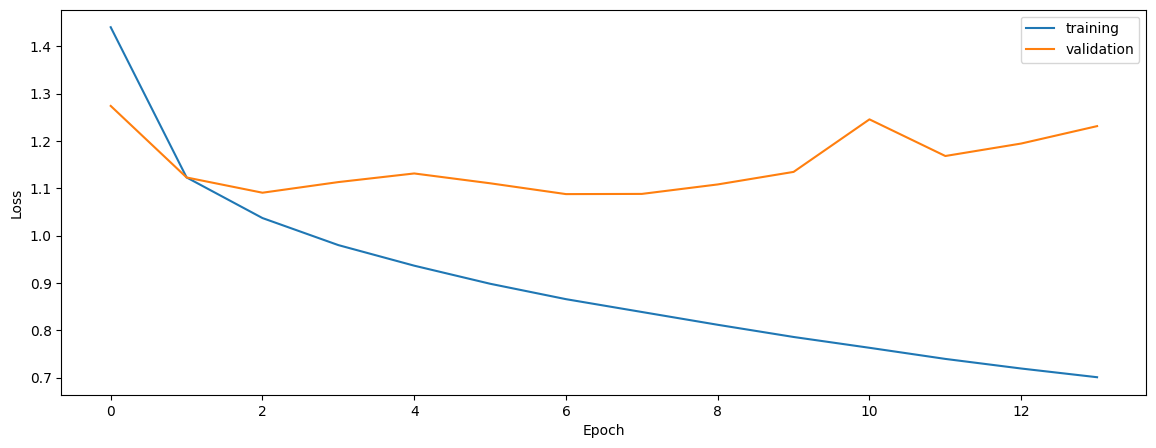

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.67730193859469
0.5721813999965543
0.5857033506141053


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.602941668567952
0.5711058519793459
0.5287400200689324


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6042091935608899
0.5658488282539333
0.5290884972522266


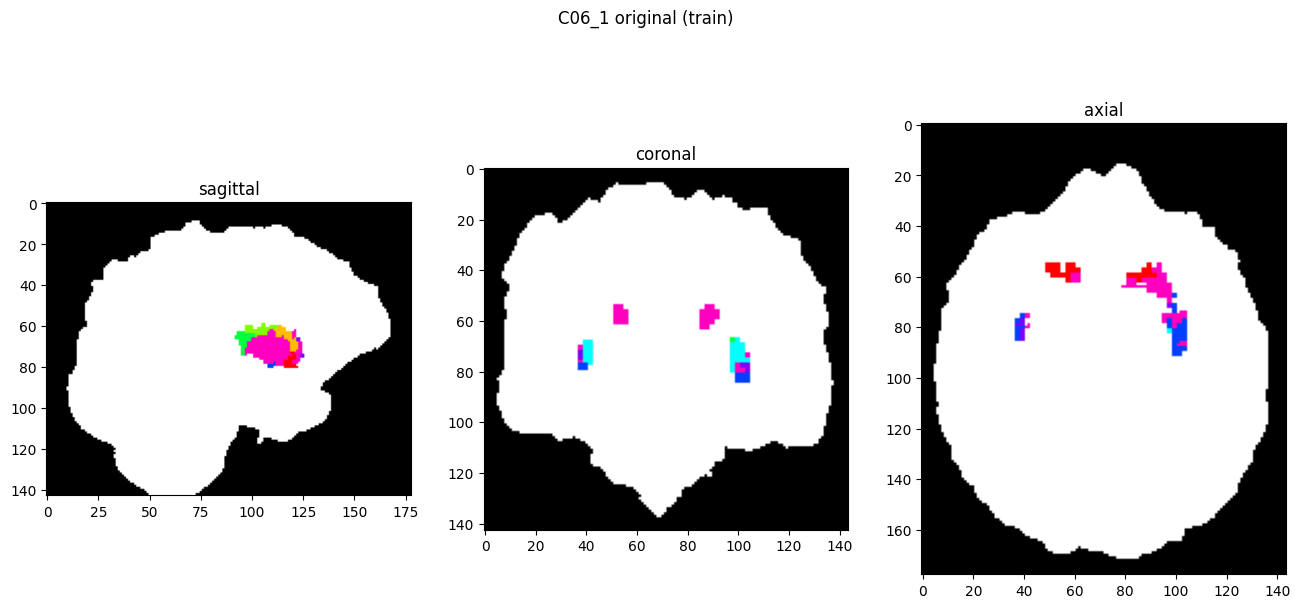

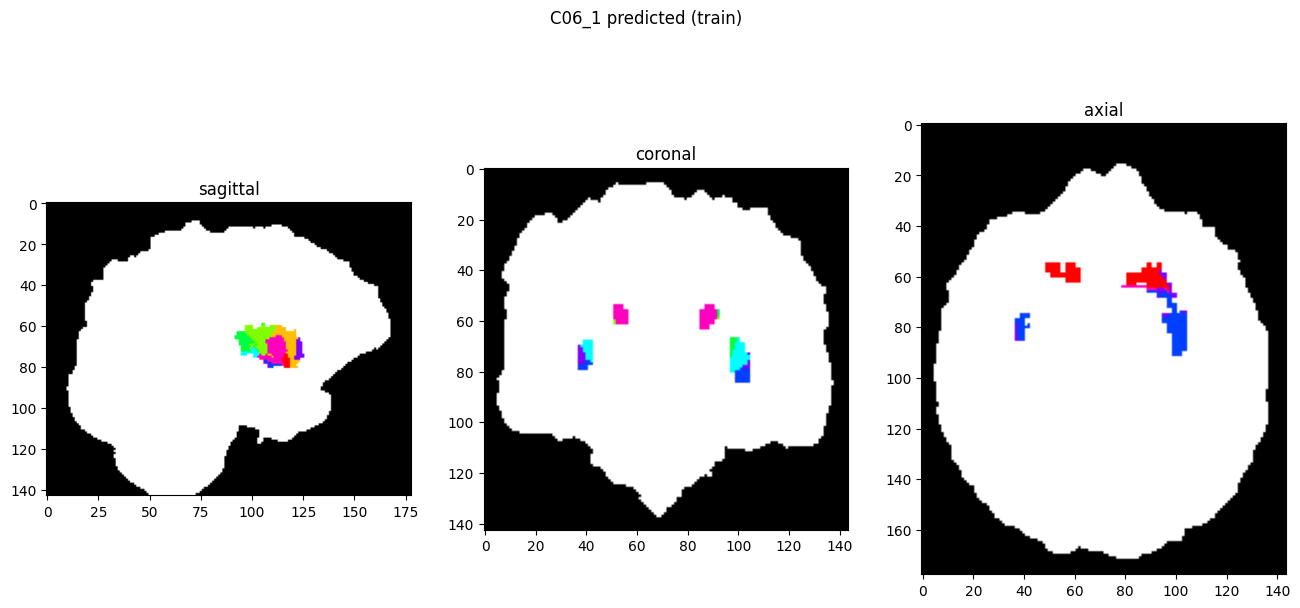

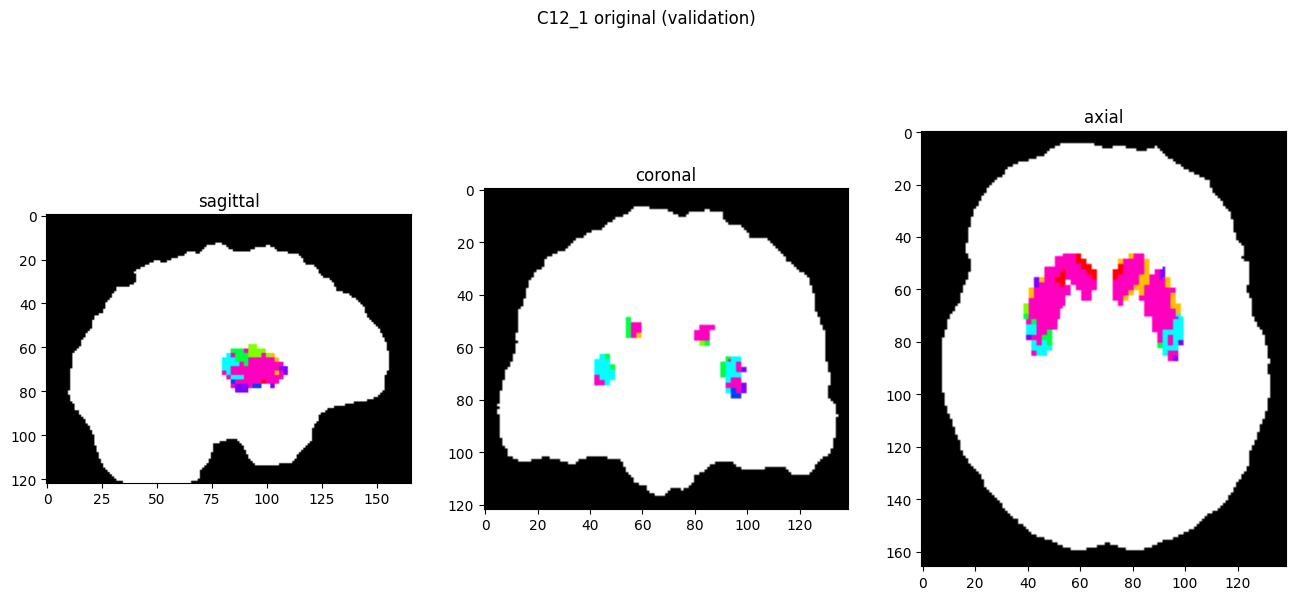

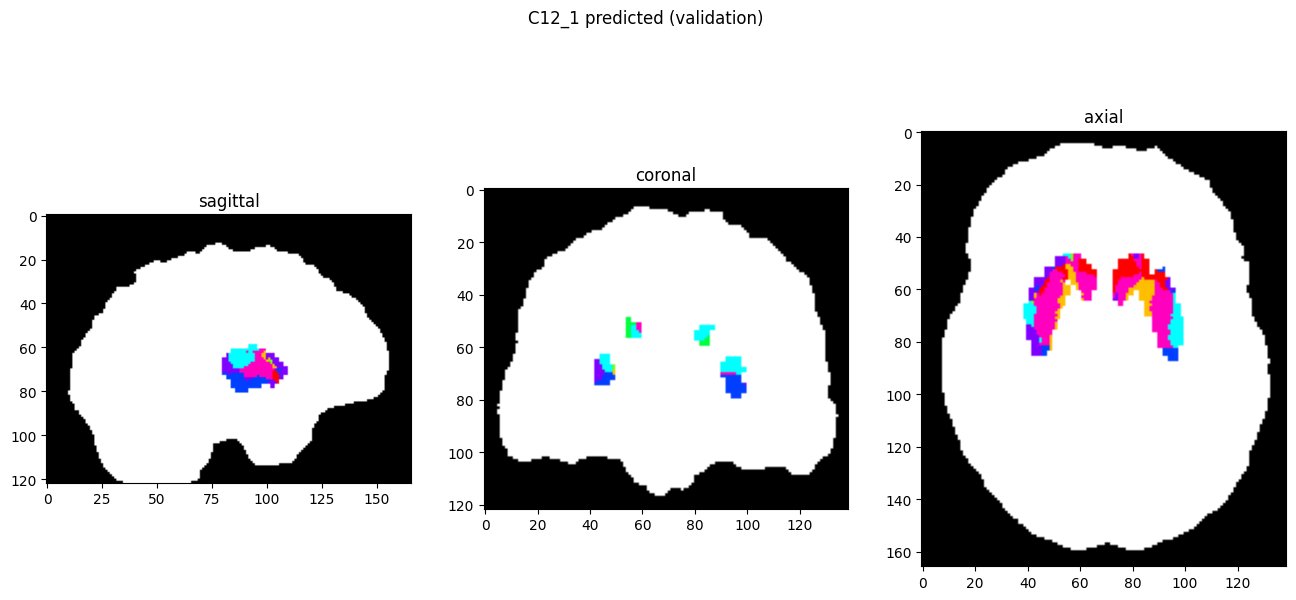

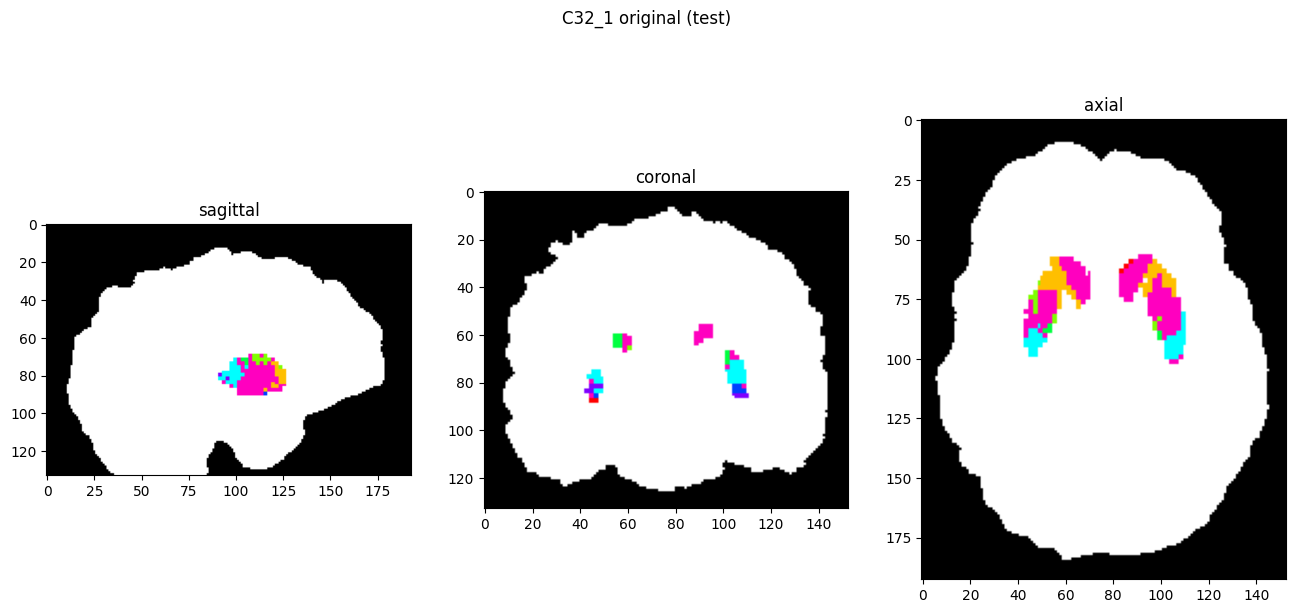

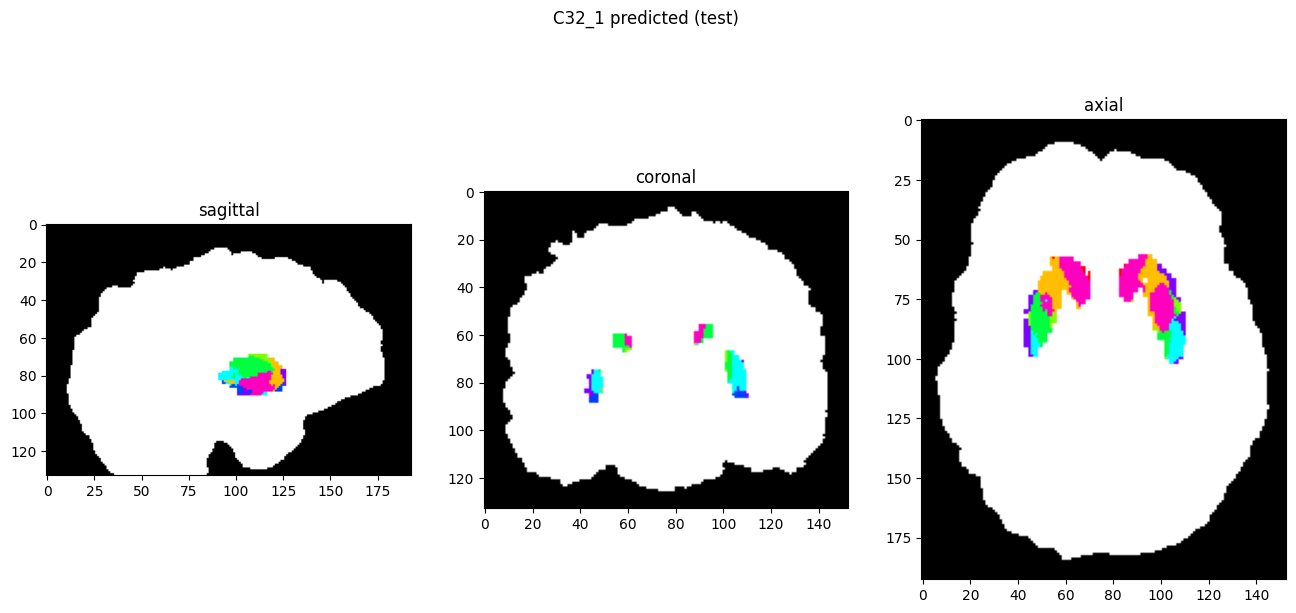

In [10]:
showResults(model, gen, threshold=0)